# Light Curve Parameter Inference Using LFI -- Tutorial

# Imports

## Python Packages

In [1]:
# general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import os, sys, time, glob
import json
import copy
import scipy
import warnings
from tqdm import tqdm

In [2]:
python3 lightcurves_to_tensors.py \
  --dir_path_var    /home/mehul/oppenheimer_recovered/summer2025/Kilo/data/varied \
  --inj_file_var    injection_varied.json \
  --label_var       test_varied \
  --dir_path_fix    /home/mehul/oppenheimer_recovered/summer2025/Kilo/data/fixed \
  --inj_file_fix    injection_fixed.json \
  --label_fix       test_fixed \
  --detection_limits 22.0 \
  --filters         ztfg,ztfr,ztfi \
  --dt              1 \
  --data_fillers    22.0 \
  --params          mej,vej,xlan,shift,distance \
  --num_repeats     50 \
  --save_lc_data_fix   fixed_data.pt \
  --save_lc_params_fix fixed_params.pt \
  --save_lc_data_var   varied_data.pt \
  --save_lc_params_var varied_params.pt


SyntaxError: invalid syntax (3260262398.py, line 1)

In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [3]:
# bilby
import bilby
from bilby.core.prior import Uniform, DeltaFunction
from bilby.core.likelihood import GaussianLikelihood

In [4]:
# nflows
from nflows.nn.nets.resnet import ResidualNet
from nflows import transforms, distributions, flows
from nflows.distributions import StandardNormal
from nflows.flows import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms import CompositeTransform, RandomPermutation
import nflows.utils as torchutils

In [5]:
# extras
from IPython.display import clear_output
from time import time
from time import sleep
import corner
import torchvision
import torchvision.transforms as transforms
from os.path import exists

## Personal Functions

In [6]:
# importing dataloading functions

# these functions are used to open the data and assign data id's
from model.data_processing import open_json, get_names, json_to_df, add_batch_sim_nums_all, get_test_names

# these functions are used to ensure the data are the same length (121 points)
from model.data_processing import pad_the_data, pad_all_dfs

# these functions are used to read in data when it is in csv format
from model.data_processing import load_in_data, match_fix_to_var, matched

# these functions are used to convert csv files to tensors and create a dataset
from model.data_processing import repeated_df_to_tensor, Paper_data

In [7]:
# importing similarity embedding functions

from model.embedding import VICRegLoss, ConvResidualBlock, ConvResidualNet, SimilarityEmbedding, train_one_epoch_se, val_one_epoch_se

# importing resnet from ML4GW pe

from model.resnet import ResNet

In [8]:
# importing normalizing flow functions

from model.normalizingflows import Flow_data, EmbeddingNet, normflow_params, train_one_epoch, val_one_epoch

In [9]:
# importing inference functions

from model.inference import cast_as_bilby_result, live_plot_samples, ppplot, comparison_plot

## Setting Device

In [10]:
# checking gpu status, ensures tensors are stored on the same device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


# Data Specific Parameters and Priors

Light curve generation is done through the nmma package on github: https://github.com/nuclear-multimessenger-astronomy/nmma/tree/main. To properly encode the effects of changing $t$ and $d_L$, each combination of our physical parameters $\log_{10}(M_{ej})$, $\log_{10}(V_{ej})$, and $\log_{10}(X_{lan})$ are repeated 50 times to produce light curves with unique noise instances. A second set of 50 light curves is created by adjusting $t$ and $d_L$ according to the priors shown below. Our training dataset contains 8,729 unique combinations of $\log_{10}(M_{ej})$, $\log_{10}(V_{ej})$, and $\log_{10}(X_{lan})$, resulting in $8,729 \times 50 \times 2 = 872,900$ total light curves.

In [11]:
# json specific parameters, adjust this cell with commands when generating light curves -- MANDATORY

bands = ['ztfg', 'ztfr', 'ztfi']
detection_limit = 22.0
num_repeats = 50
num_channels = 3
num_points = 33
in_features = num_points
data_dir = '/nobackup/users/mmdesai/new_csv/'

In [12]:
# time shift

t_zero = 44242.00021937881
t_min = 44240.0012975024
t_max = 44269.99958898723
days = int(round(t_max - t_min))
time_step = 1

In [13]:
# priors

priors = dict()
priors['log10_mej'] = Uniform(-1.9, -1, name='log10_mej', latex_label='$\log(M_{{ej}})$')
priors['log10_vej'] = Uniform(-1.52, -0.53, name='log10_vej', latex_label='$\log(V_{{ej}})$')
priors['log10_Xlan'] = Uniform(-9, -3, name='log10_Xlan', latex_label='$\log(X_{{lan}})$')
priors['timeshift'] = Uniform(-2, 6, name='timeshift', latex_label='$\Delta\;t$')
priors['distance'] = Uniform(50, 200, name='luminosity distance', latex_label='$D$')

In [14]:
print(priors)

{'log10_mej': Uniform(minimum=-1.9, maximum=-1, name='log10_mej', latex_label='$\\log(M_{{ej}})$', unit=None, boundary=None), 'log10_vej': Uniform(minimum=-1.52, maximum=-0.53, name='log10_vej', latex_label='$\\log(V_{{ej}})$', unit=None, boundary=None), 'log10_Xlan': Uniform(minimum=-9, maximum=-3, name='log10_Xlan', latex_label='$\\log(X_{{lan}})$', unit=None, boundary=None), 'timeshift': Uniform(minimum=-2, maximum=6, name='timeshift', latex_label='$\\Delta\\;t$', unit=None, boundary=None), 'distance': Uniform(minimum=50, maximum=200, name='luminosity distance', latex_label='$D$', unit=None, boundary=None)}


# Data Processing

This section processes data generated through NMMA. Use this section as a guide for converting the .json files into dataframes. The dataframes are subsequently stored as .csv files. If using the data from Zenodo, skip ahead to the Tensor Processing section. 

### Varied Data

In [ ]:
dir_path       = '/home/oppenheimer/summer2025/Kilo/data/lc_dir/varied/'
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']

In [ ]:
# your existing helper to open a single .json
def open_json(file_name, dir_path):
    with open(os.path.join(dir_path, file_name)) as f:
        return json.load(f)

# your existing json → DataFrame function
def json_to_df(file_name, dir_path, detection_limit, bands):
    data = open_json(file_name, dir_path)
    df = pd.DataFrame.from_dict(data, orient="columns")
    df_unpacked = pd.DataFrame(columns=['t'] + bands)
    counter = 0
    for j, band in enumerate(bands):
        # unpack each band’s [t, value, x]
        df_unpacked[['t', band, 'x']] = pd.DataFrame(
            df[band].tolist(), index=df.index
        )
        counter += (df_unpacked[band] != detection_limit).sum()
    df_unpacked['num_detections'] = counter
    return df_unpacked.drop(columns=['x'])

# parameters
dir_path       = '/home/oppenheimer/summer2025/Kilo/data/varied/'
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
# find all your test_*.json files
file_pattern = os.path.join(dir_path, 'test_varied_*.json')
all_files    = sorted(glob.glob(file_pattern))  # gives absolute paths

# process them all into a list of DataFrames
df_list = [
    json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    for fp in all_files
]

print(len(df_list), "files found.")
# if you want one big DataFrame
df_all = pd.concat(df_list, ignore_index=True)

# now df_all contains the flattened photometry from all 25 000 files
print(df_all.shape)  


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
# dir_path        = "/path/to/your/jsons"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 10000        # how many sims to process per batch
batch_size      = 50          # sims per batch for batch_id
# output_csv      = "all_lightcurves_varied.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
t_min = np.floor(raw_min)
t_max = np.ceil(raw_max) + step

In [280]:
dir_path = '/home/mehul/summer2025/Kilo/varied_4/'
detection_limit = 22.0
bands = ['ztfg', 'ztfr', 'ztfi']

In [282]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
# dir_path        = "/path/to/your/jsons"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 2000        # how many sims to process per batch
batch_size      = 50          # sims per batch for batch_id
output_csv      = "all_lightcurves_varied_4.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
t_min = np.floor(raw_min)
t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size
        df['batch_id'] = df['batch_id']

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_all = pd.read_csv(output_csv)
print("Final table shape:", df_all.shape)
print("Time spans:", df_all['t'].min(), "→", df_all['t'].max())
print("Unique batch_ids:", sorted(df_all['batch_id'].unique()))


100%|██████████| 2000/2000 [00:03<00:00, 632.00it/s]


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.in

In [77]:
output_csv      = "/home/mehul/summer2025/Kilo/all_lightcurves_varied_0.csv"

df_all = pd.read_csv(output_csv)
print("Final table shape:", df_all.shape)
print("Time spans:", df_all['t'].min(), "→", df_all['t'].max())
print("Unique batch_ids:", sorted(df_all['batch_id'].unique()))

t_min = df_all['t'].min()
t_max = df_all['t'].max()
print(f"Extracted t_min: {t_min}, t_max: {t_max}")


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.in

In [16]:
#print list of sim_ids
sim_ids = df_all['sim_id'].unique()
print("Unique sim_ids:", sorted(sim_ids))

Unique sim_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70),

In [ ]:
import torch

#save df_all as a tensor
fixed_data_4  = torch.tensor(df_all.values, dtype=torch.float32)

torch.save(fixed_data_4, "varied_data_4.pt")

print(fixed_data_4.shape)

In [ ]:
#load a saved pytorch tensor file
# data = torch.load('varied_data_1.pt')
#add 100,000 to 5th column of the tensor
# data[1][:, 4] += 100000
# #add 2000 to 7th column of the tensor
# data[1][:, 6] += 2000
# #save the modified tensor
# torch.save(data, 'varied_data_1.pt')
data = torch.load('varied_data_0.pt')

# Make a copy before modifying
modified_tensor = data.clone()

# modified_tensor[:, 4] += 300_000
# modified_tensor[:, 6] += 6_000

# # Replace in data
# # data = modified_tensor

# torch.save(modified_tensor, 'varied_data_3.pt')


print(modified_tensor[3299999])

In [17]:
# print(df_list[3])
# print(padded_list[3])

#print df_all with a particular sim_id
sim_id = 10  # change this to the sim_id you want to inspect
df_sim = df_all[df_all['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 10:
                 t       ztfg       ztfr       ztfi  sim_id  num_detections  \
330  44240.000000  22.000000  22.000000  22.000000      10              22   
331  44241.000000  22.000000  22.000000  22.000000      10              22   
332  44242.000000  22.000000  22.000000  22.000000      10              22   
333  44243.000000  22.000000  22.000000  22.000000      10              22   
334  44244.000000  22.000000  22.000000  22.000000      10              22   
335  44245.000000  22.000000  22.000000  22.000000      10              22   
336  44245.503357  22.000000  22.000000  22.000000      10              22   
337  44246.503357  22.000000  22.000000  22.000000      10              22   
338  44247.503357  22.000000  22.000000  22.000000      10              22   
339  44248.503357  20.431398  21.258602  21.845142      10              22   
340  44249.503357  20.165133  20.585804  21.058741      10              22   
341  44250.503357  20.976617  20.350687  20

In [8]:
varied_simembed_dict = {}

In [ ]:
# get the varied data

sim_path = '/nobackup/users/mmdesai/lowcsimdata'
num_sims = 25000

simembed_num_lc_list = [24750, 25000, 25000, 25000, 25000, 25000, 24850, 25000, 25000, 25000]

for i in range (0, 10):
    # get the names of each file
    file_names = get_names(sim_path, 'varied', i, simembed_num_lc_list[i])
    # open the files as dataframes
    varied_simembed_dict['varied_simembed_data_{}'.format(i)] = json_to_df(file_names, simembed_num_lc_list[i])
    # pad the data
    varied_simembed_dict['varied_simembed_data_{}'.format(i)] = pad_all_dfs(varied_simembed_dict['varied_simembed_data_{}'.format(i)])

In [ ]:
varied_simembed_dict['varied_simembed_data_0'][-1]

In [ ]:
# plot a small sample of the varied light curves

for i in range(0, 300, 50):
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(varied_simembed_dict['varied_simembed_data_0'][i]['t'], varied_simembed_dict['varied_simembed_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [78]:
inj_path_simembed = '/home/mehul/summer2025/Kilo/varied_data/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

             mej       vej      xlan     shift    distance  sim_id
0      -1.848528 -1.370628 -5.185782 -0.518525  168.344934       0
1      -1.848528 -1.370628 -5.185782  0.293515  168.344934       1
2      -1.848528 -1.370628 -5.185782  5.388985  168.344934       2
3      -1.848528 -1.370628 -5.185782  0.751994  168.344934       3
4      -1.848528 -1.370628 -5.185782  3.501260  168.344934       4
...          ...       ...       ...       ...         ...     ...
499995 -1.796626 -1.276093 -4.247074  3.274288  152.176440  499995
499996 -1.796626 -1.276093 -4.247074  5.667442  152.176440  499996
499997 -1.796626 -1.276093 -4.247074 -1.640874  152.176440  499997
499998 -1.796626 -1.276093 -4.247074 -0.801628  152.176440  499998
499999 -1.796626 -1.276093 -4.247074  2.422283  152.176440  499999

[500000 rows x 6 columns]


In [79]:
#extract 100000 to 190000 rows from varied_injections
varied_injections = varied_injections.iloc[:100000]
#subtract 100000 from sim_id
# varied_injections['sim_id'] -= 400000
print(varied_injections)

            mej       vej      xlan     shift    distance  sim_id
0     -1.848528 -1.370628 -5.185782 -0.518525  168.344934       0
1     -1.848528 -1.370628 -5.185782  0.293515  168.344934       1
2     -1.848528 -1.370628 -5.185782  5.388985  168.344934       2
3     -1.848528 -1.370628 -5.185782  0.751994  168.344934       3
4     -1.848528 -1.370628 -5.185782  3.501260  168.344934       4
...         ...       ...       ...       ...         ...     ...
99995 -1.563679 -1.071401 -8.323287  2.933847  162.032632   99995
99996 -1.563679 -1.071401 -8.323287 -1.410544  162.032632   99996
99997 -1.563679 -1.071401 -8.323287  5.819007  162.032632   99997
99998 -1.563679 -1.071401 -8.323287  0.186908  162.032632   99998
99999 -1.563679 -1.071401 -8.323287 -0.948739  162.032632   99999

[100000 rows x 6 columns]


In [80]:
print(varied_injections)

            mej       vej      xlan     shift    distance  sim_id
0     -1.848528 -1.370628 -5.185782 -0.518525  168.344934       0
1     -1.848528 -1.370628 -5.185782  0.293515  168.344934       1
2     -1.848528 -1.370628 -5.185782  5.388985  168.344934       2
3     -1.848528 -1.370628 -5.185782  0.751994  168.344934       3
4     -1.848528 -1.370628 -5.185782  3.501260  168.344934       4
...         ...       ...       ...       ...         ...     ...
99995 -1.563679 -1.071401 -8.323287  2.933847  162.032632   99995
99996 -1.563679 -1.071401 -8.323287 -1.410544  162.032632   99996
99997 -1.563679 -1.071401 -8.323287  5.819007  162.032632   99997
99998 -1.563679 -1.071401 -8.323287  0.186908  162.032632   99998
99999 -1.563679 -1.071401 -8.323287 -0.948739  162.032632   99999

[100000 rows x 6 columns]


In [ ]:
#save the varied injections as a tensor
varied_inj_tensor = torch.tensor(varied_injections.values, dtype=torch.float32)
torch.save(varied_inj_tensor, "varied_inj_tensor.pt")

In [ ]:
#stack varied_data_0 and varied_data_1 and so on till 4
varied_data_0 = torch.load('varied_data_0.pt')
varied_data_1 = torch.load('varied_data_1.pt')
varied_data_2 = torch.load('varied_data_2.pt')
varied_data_3 = torch.load('varied_data_3.pt')
varied_data_4 = torch.load('varied_data_4.pt')
varied_data = torch.stack((varied_data_0, varied_data_1, varied_data_2, varied_data_3, varied_data_4), dim=0)

In [81]:
# if your varied_injections DataFrame calls its sim key something else, rename it:
# varied_injections = varied_injections.rename(columns={ 'simulation_id': 'sim_id' })

# select only the columns you care about from injections
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final = df_all.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final.shape)  # should be (~3 300 000, original_cols+5)


Final shape: (3300000, 12)


In [22]:
# print a particular sim_id
sim_id = 10  # change this to the sim_id you want to inspect
df_sim = df_final[df_final['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 10:
                 t       ztfg       ztfr       ztfi  sim_id  num_detections  \
330  44240.000000  22.000000  22.000000  22.000000      10              22   
331  44241.000000  22.000000  22.000000  22.000000      10              22   
332  44242.000000  22.000000  22.000000  22.000000      10              22   
333  44243.000000  22.000000  22.000000  22.000000      10              22   
334  44244.000000  22.000000  22.000000  22.000000      10              22   
335  44245.000000  22.000000  22.000000  22.000000      10              22   
336  44245.503357  22.000000  22.000000  22.000000      10              22   
337  44246.503357  22.000000  22.000000  22.000000      10              22   
338  44247.503357  22.000000  22.000000  22.000000      10              22   
339  44248.503357  20.431398  21.258602  21.845142      10              22   
340  44249.503357  20.165133  20.585804  21.058741      10              22   
341  44250.503357  20.976617  20.350687  20

In [27]:
merged_list = []
for i, df in enumerate(padded_list):
    inj = varied_injections.iloc[i]  # a Series with index ['mej','vej',…,'sim_id']
    # drop the sim_id from inj if you don’t want to re–assign it
    for col in ['mej','vej','xlan','shift','distance']:
        df[col] = inj[col]
    merged_list.append(df)

# finally, glue them all together
df_final = pd.concat(merged_list, ignore_index=True)
print(df_final)

NameError: name 'padded_list' is not defined

In [ ]:
# print df_final with a particular sim_id
print(df_final[df_final['sim_id'] == 24999])

In [ ]:
# injection files for the additional data

inj_path_simembed = '/nobackup/users/mmdesai/final_injections'
varied_injections = {}

for i in range(0, 10):
    varied_inj_df = pd.DataFrame()
    varied_params = open_json('/injection_simembed_varied_{}.json'.format(i), inj_path_simembed)
    varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
    varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
    varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
    varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
    varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
    varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
    varied_injections['varied_inj_df{}'.format(i)] = varied_inj_df

In [ ]:
varied_injections['varied_inj_df0']

In [ ]:
# concatenate dataframe lists

all_varied_data_list = [0] * 10

for i in range(0, 10):
    all_varied_data_list[i] = pd.concat(varied_simembed_dict['varied_simembed_data_{}'.format(i)])

In [ ]:
# merge with injection parameters

all_varied_datawparams_list = [0] * 10

for i in range(0, 10):
    all_varied_datawparams_list[i] = all_varied_data_list[i].merge(varied_injections['varied_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_varied_datawparams_list[i].to_csv('/nobackup/users/mmdesai/final_csv/varied_lowc_{}.csv'.format(i), index = False)

In [ ]:
all_varied_datawparams_list[0]

### Fixed Data

In [289]:
dir_path= '/home/mehul/summer2025/Kilo/data/fixed4/'
detection_limit = 22.0
bands= ['ztfg', 'ztfr', 'ztfi']

In [290]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
# dir_path        = "/path/to/your/jsons"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 5000        # how many sims to process per batch
batch_size      = 50          # sims per batch for batch_id
output_csv      = "all_lightcurves_fixed_2.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_fixed_all = pd.read_csv(output_csv)
print("Final table shape:", df_fixed_all.shape)
print("Time spans:", df_fixed_all['t'].min(), "→", df_fixed_all['t'].max())
print("Unique batch_ids:", sorted(df_fixed_all['batch_id'].unique()))


100%|██████████| 5000/5000 [00:06<00:00, 740.47it/s]


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.in

In [82]:
output_csv = "/home/mehul/summer2025/Kilo/all_lightcurves_fixed_0.csv"

df_fixed_all = pd.read_csv(output_csv)
print("Final table shape:", df_fixed_all.shape)
print("Time spans:", df_fixed_all['t'].min(), "→", df_fixed_all['t'].max())
print("Unique batch_ids:", sorted(df_fixed_all['batch_id'].unique()))


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.in

In [83]:
# print(padded_fixed_list[5])
# print(df_fixed_list[5])

# print df_fixed_all with a particular sim_id
sim_id = 10  # change this to the sim_id you want to inspect
df_sim = df_fixed_all[df_fixed_all['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 10:
                 t       ztfg       ztfr       ztfi  sim_id  num_detections  \
330  44240.000000  22.000000  22.000000  22.000000      10              51   
331  44241.000000  22.000000  22.000000  22.000000      10              51   
332  44242.000000  22.000000  22.000000  22.000000      10              51   
333  44242.000221  22.000000  22.000000  22.000000      10              51   
334  44243.000221  22.000000  22.000000  22.000000      10              51   
335  44244.000221  22.000000  22.000000  22.000000      10              51   
336  44245.000221  17.945052  18.617851  18.871375      10              51   
337  44246.000221  17.615346  17.901349  18.312283      10              51   
338  44247.000221  18.474157  17.821349  18.135519      10              51   
339  44248.000221  19.072111  17.993263  18.049714      10              51   
340  44249.000221  19.948261  18.358691  18.302553      10              51   
341  44250.000221  20.750042  18.649223  18

In [84]:
inj_path_simembed = '/home/mehul/summer2025/Kilo/data/fixed/'

fixed_inj_df = pd.DataFrame()
fixed_params = open_json('injection_fixed.json', inj_path_simembed)
fixed_inj_df['mej'] = fixed_params['injections']['content']['log10_mej']
fixed_inj_df['vej'] = fixed_params['injections']['content']['log10_vej']
fixed_inj_df['xlan'] = fixed_params['injections']['content']['log10_Xlan']
fixed_inj_df['shift'] = fixed_params['injections']['content']['timeshift']
fixed_inj_df['distance'] = fixed_params['injections']['content']['luminosity_distance']
fixed_inj_df['sim_id'] = fixed_params['injections']['content']['simulation_id']
fixed_injections = fixed_inj_df

print(fixed_injections)

             mej       vej      xlan  shift  distance  sim_id
0      -1.848528 -1.370628 -5.185782      0        50       0
1      -1.848528 -1.370628 -5.185782      0        50       1
2      -1.848528 -1.370628 -5.185782      0        50       2
3      -1.848528 -1.370628 -5.185782      0        50       3
4      -1.848528 -1.370628 -5.185782      0        50       4
...          ...       ...       ...    ...       ...     ...
499995 -1.796626 -1.276093 -4.247074      0        50  499995
499996 -1.796626 -1.276093 -4.247074      0        50  499996
499997 -1.796626 -1.276093 -4.247074      0        50  499997
499998 -1.796626 -1.276093 -4.247074      0        50  499998
499999 -1.796626 -1.276093 -4.247074      0        50  499999

[500000 rows x 6 columns]


In [85]:
#extract 400000 to 500000 rows from fixed_injections
fixed_injections = fixed_injections.iloc[:100000]
#subtract 400000 from sim_id
# fixed_injections['sim_id'] -= 400000
print(fixed_injections)

            mej       vej      xlan  shift  distance  sim_id
0     -1.848528 -1.370628 -5.185782      0        50       0
1     -1.848528 -1.370628 -5.185782      0        50       1
2     -1.848528 -1.370628 -5.185782      0        50       2
3     -1.848528 -1.370628 -5.185782      0        50       3
4     -1.848528 -1.370628 -5.185782      0        50       4
...         ...       ...       ...    ...       ...     ...
99995 -1.563679 -1.071401 -8.323287      0        50   99995
99996 -1.563679 -1.071401 -8.323287      0        50   99996
99997 -1.563679 -1.071401 -8.323287      0        50   99997
99998 -1.563679 -1.071401 -8.323287      0        50   99998
99999 -1.563679 -1.071401 -8.323287      0        50   99999

[100000 rows x 6 columns]


In [86]:
# if your varied_injections DataFrame calls its sim key something else, rename it:
# varied_injections = varied_injections.rename(columns={ 'simulation_id': 'sim_id' })

# select only the columns you care about from injections
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_fixed_final = df_fixed_all.merge(
    fixed_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_fixed_final.shape)  # should be (~3 300 000, original_cols+5)


Final shape: (3300000, 12)


In [ ]:
merged_fixed_list = []
for i, df in enumerate(padded_fixed_list):
    inj = fixed_injections.iloc[i]  # a Series with index ['mej','vej',…,'sim_id']
    # drop the sim_id from inj if you don’t want to re–assign it
    for col in ['mej','vej','xlan','shift','distance']:
        df[col] = inj[col]
    merged_fixed_list.append(df)

# finally, glue them all together
df_fixed_final = pd.concat(merged_fixed_list, ignore_index=True)
print(df_fixed_final)

In [297]:
#print df_fixed_final with a particular sim_id
print(df_fixed_final[df_fixed_final['sim_id'] == 0])

              t       ztfg       ztfr       ztfi  sim_id  num_detections  \
0   44240.00000  22.000000  22.000000  22.000000       0              29   
1   44241.00000  22.000000  22.000000  22.000000       0              29   
2   44242.00000  22.000000  22.000000  22.000000       0              29   
3   44242.00022  22.000000  22.000000  22.000000       0              29   
4   44243.00022  22.000000  22.000000  22.000000       0              29   
5   44244.00022  22.000000  22.000000  22.000000       0              29   
6   44245.00022  18.297613  18.809966  19.279173       0              29   
7   44246.00022  19.132225  18.605950  19.145857       0              29   
8   44247.00022  20.240469  19.135078  19.023873       0              29   
9   44248.00022  21.687005  19.520490  18.746335       0              29   
10  44249.00022  22.121573  19.955727  19.757584       0              29   
11  44250.00022  22.000000  20.130171  20.341015       0              29   
12  44251.00

In [ ]:
fixed_simembed_dict = {}

In [ ]:
# get the fixed data

sim_path = '/nobackup/users/mmdesai/lowcsimdata'
num_sims = 25000

simembed_num_lc_list = [24900, 25000, 25000, 25000, 25000, 25000, 25000, 24800, 25000, 25000]

for i in range(0, 10):
    # get the names of each file
    file_names = get_names(sim_path, 'fixed', i, simembed_num_lc_list[i])
    # open the files as dataframes
    fixed_simembed_dict['fixed_simembed_data_{}'.format(i)] = json_to_df(file_names, simembed_num_lc_list[i])
    # pad the data
    fixed_simembed_dict['fixed_simembed_data_{}'.format(i)] = pad_all_dfs(fixed_simembed_dict['fixed_simembed_data_{}'.format(i)])

In [ ]:
fixed_simembed_dict['fixed_simembed_data_0'][-1]

In [ ]:
for i in range(0, 300, 50):
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(fixed_simembed_dict['fixed_simembed_data_0'][i]['t'], fixed_simembed_dict['fixed_simembed_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [ ]:
#plot lightcurves from padded_fixed_list
import matplotlib.pyplot as plt

first_n = 3
plt.figure(figsize=(10, 6))

for i in range(first_n):
    df = padded_fixed_list[i]
    bands = ['ztfg']
    for band in bands:
        plt.scatter(df['t'], df[band], label=f"{band} (sim {i})")

plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title(f"First {first_n} Light Curves Overlapped in All Three Bands")
plt.legend(loc="upper right", ncol=first_n)  # adjust layout if it’s crowded
plt.tight_layout()
plt.show()

In [ ]:
#plot lightcurves from padded_fixed_list
import matplotlib.pyplot as plt

first_n = 3
plt.figure(figsize=(10, 6))

for i in range(first_n):
    df = padded_fixed_list[i]
    bands = ['ztfr']
    for band in bands:
        plt.scatter(df['t'], df[band], label=f"{band} (sim {i})")

plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title(f"First {first_n} Light Curves Overlapped in All Three Bands")
plt.legend(loc="upper right", ncol=first_n)  # adjust layout if it’s crowded
plt.tight_layout()
plt.show()

In [ ]:
#plot lightcurves from padded_fixed_list
import matplotlib.pyplot as plt

first_n = 3
plt.figure(figsize=(10, 6))

for i in range(first_n):
    df = padded_fixed_list[i]
    bands = ['ztfi']
    for band in bands:
        plt.scatter(df['t'], df[band], label=f"{band} (sim {i})")

plt.gca().invert_yaxis()
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title(f"First {first_n} Light Curves Overlapped in All Three Bands")
plt.legend(loc="upper right", ncol=first_n)  # adjust layout if it’s crowded
plt.tight_layout()
plt.show()

In [ ]:
# injection files

inj_path_simembed = '/nobackup/users/mmdesai/final_injections'
fixed_injections = {}

for i in range(0, 10):
    fixed_inj_df = pd.DataFrame()
    fixed_params = open_json('/injection_simembed_fixed_{}.json'.format(i), inj_path_simembed)
    fixed_inj_df['mej'] = fixed_params['injections']['content']['log10_mej']
    fixed_inj_df['vej'] = fixed_params['injections']['content']['log10_vej']
    fixed_inj_df['xlan'] = fixed_params['injections']['content']['log10_Xlan']
    fixed_inj_df['shift'] = fixed_params['injections']['content']['timeshift']
    fixed_inj_df['distance'] = fixed_params['injections']['content']['luminosity_distance']
    fixed_inj_df['sim_id'] = fixed_params['injections']['content']['simulation_id']
    fixed_injections['fixed_inj_df{}'.format(i)] = fixed_inj_df

In [ ]:
fixed_injections['fixed_inj_df0']

In [ ]:
# concatenate dataframe lists

all_fixed_data_list = [0] * 10

for i in range(0, 10):
    all_fixed_data_list[i] = pd.concat(fixed_simembed_dict['fixed_simembed_data_{}'.format(i)])

In [ ]:
# merge with injection parameters

all_fixed_datawparams_list = [0] * 10

for i in range(0, 10):
    all_fixed_datawparams_list[i] = all_fixed_data_list[i].merge(fixed_injections['fixed_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_fixed_datawparams_list[i].to_csv('/nobackup/users/mmdesai/final_csv/fixed_lowc_{}.csv'.format(i), index = False)

In [ ]:
all_fixed_datawparams_list[0]

# Load in Data

If the data is stored as a .csv file, use this section to further process the data and import it to the notebook. This section ensures that the fixed (unshifted) and shifted light curves are properly paired and assigns each light curve a unique simulation id (sim_id). Batch numbers are also added, with 50 light curves in a batch. Each set of 50 light curves have the same mass, velocity, and lanthanide fraction of the ejecta. The fixed ones peak at the same time and are set to a luminosity distance of 50 Mpc, while the 50 repeated shifted light curves have a time and distance generated from a uniform prior. We also set the condition for number of detections in this section.

In [ ]:
# directory where the csv files are stored

data_dir = '/nobackup/users/mmdesai/final_csv/'

In [ ]:
# set the minimum number of detections needed

min_num_detections = 8

## First Batch

In [ ]:
matched_df1 = matched(data_dir, 'varied', 'fixed', 0, 10) 

In [ ]:
add_batch_sim_nums_all(matched_df1)
matched_df1

In [ ]:
true_list1 = []
for i in range(int(len(matched_df1)/num_points/50)):
    batch_df = matched_df1.loc[matched_df1['batch_id'] == i]
    if batch_df['num_detections_x'].min() >= min_num_detections:
        true_list1.append(batch_df)
    else:
        pass

In [ ]:
detected_df1 = pd.concat(true_list1)
detected_df1

In [ ]:
# varied

var_df = detected_df1.iloc[:, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

In [ ]:
# fixed

fix_df = detected_df1.iloc[:, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

## Second Batch

In [ ]:
matched_df2 = matched(data_dir, 'varied', 'fixed', 10, 20) 

In [ ]:
add_batch_sim_nums_all(matched_df2)
new_df2

In [ ]:
true_list2 = []
for i in range(int(len(matched_df2)/121/50)):
    batch_df = matched_df2.loc[matched_df2['batch_id'] == i]
    if batch_df['num_detections_x'].min() >= min_num_detections:
        true_list2.append(batch_df)
    else:
        pass

In [ ]:
detected_df2 = pd.concat(true_list2)
detected_df2

In [ ]:
# varied

var_df = detected_df2.iloc[:, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

In [ ]:
# fixed

fix_df = detected_df2.iloc[:, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

In [87]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_varied = df_final[desired_order]
df_fixed = df_fixed_final[desired_order]

In [88]:
# df_varied
# print df_varied with a particular sim_id
sim_id = 0  # change this to the sim_id you want to inspect
df_sim = df_varied[df_varied['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 0:
                t       ztfg       ztfr       ztfi  num_detections       mej  \
0   44240.000000  22.000000  22.000000  22.000000               7 -1.848528   
1   44241.000000  22.000000  22.000000  22.000000               7 -1.848528   
2   44241.481695  22.000000  22.000000  22.000000               7 -1.848528   
3   44242.481695  22.000000  22.000000  22.000000               7 -1.848528   
4   44243.481695  22.000000  22.000000  22.000000               7 -1.848528   
5   44244.481695  21.190660  21.880612  22.000000               7 -1.848528   
6   44245.481695  21.751122  21.572187  21.533238               7 -1.848528   
7   44246.481695  22.000000  21.897385  21.803396               7 -1.848528   
8   44247.481695  22.000000  22.000000  22.000000               7 -1.848528   
9   44248.481695  22.000000  22.000000  22.000000               7 -1.848528   
10  44249.481695  22.000000  22.000000  22.000000               7 -1.848528   
11  44250.481695  22.000000  22.

In [89]:
# df_fixed
# print df_varied with a particular sim_id
sim_id = 0  # change this to the sim_id you want to inspect
df_sim = df_fixed[df_fixed['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 0:
               t       ztfg       ztfr       ztfi  num_detections       mej  \
0   44240.00000  22.000000  22.000000  22.000000              31 -1.848528   
1   44241.00000  22.000000  22.000000  22.000000              31 -1.848528   
2   44242.00000  22.000000  22.000000  22.000000              31 -1.848528   
3   44242.00022  22.000000  22.000000  22.000000              31 -1.848528   
4   44243.00022  22.000000  22.000000  22.000000              31 -1.848528   
5   44244.00022  22.000000  22.000000  22.000000              31 -1.848528   
6   44245.00022  18.625535  19.028402  19.314956              31 -1.848528   
7   44246.00022  19.263300  18.856958  19.215937              31 -1.848528   
8   44247.00022  20.785199  19.267573  19.246079              31 -1.848528   
9   44248.00022  21.835469  19.778219  19.564210              31 -1.848528   
10  44249.00022  22.000000  20.275011  19.872721              31 -1.848528   
11  44250.00022  22.000000  20.811443  20.13

# Tensor Processing

In [15]:
def repeated_df_to_tensor(df_varied, df_fixed, batches):
    '''
    Converts dataframes into pytorch tensors
    Inputs:
        df_varied: dataframe containing the shifted light curve information
        df_fixed: dataframe containing the analagous fixed light curve information
        batches: number of unique mass, velocity, and lanthanide injections
    Outputs:
        data_shifted_list: list of tensors of shape [repeats, channels, num_points] containing the shifted light curve photometry
        data_unshifted_list: list of tensors of shape [repeats, channels, num_points] containing the fixed light curve photometry
        param_shifted_list: list of tensors of shape [repeats, 1, 5] containing the injection parameters of the shifted light curves
        param_unshifted_list: list of tensors of shape [repeats, 1, 5] containing the injection parameters of the fixed light curves
    '''
    data_shifted_list = []
    data_unshifted_list = []
    param_shifted_list = []
    param_unshifted_list = []
    for idx in tqdm(range(0, batches)):
        data_shifted = torch.tensor(df_varied.loc[df_varied['batch_id'] == idx].iloc[:, 1:4].values.reshape(num_repeats, num_points, num_channels), 
                                    dtype=torch.float32).transpose(1, 2)
        data_unshifted = torch.tensor(df_fixed.loc[df_fixed['batch_id'] == idx].iloc[:, 1:4].values.reshape(num_repeats, num_points, num_channels), 
                                    dtype=torch.float32).transpose(1, 2)
        param_shifted = torch.tensor(df_varied.loc[df_varied['batch_id'] == idx].iloc[::num_points, 5:10].values, 
                                    dtype=torch.float32).unsqueeze(2).transpose(1,2)
        param_unshifted = torch.tensor(df_fixed.loc[df_fixed['batch_id'] == idx].iloc[::num_points, 5:10].values, 
                                    dtype=torch.float32).unsqueeze(2).transpose(1,2)
        data_shifted_list.append(data_shifted)
        data_unshifted_list.append(data_unshifted)
        param_shifted_list.append(param_shifted)
        param_unshifted_list.append(param_unshifted)
    return data_shifted_list, data_unshifted_list, param_shifted_list, param_unshifted_list

In [91]:
# moving the data to tensors on gpu -- ONLY RUN IF YOU ARE USING DATA FROM A CSV FILE
num_repeats = 50
num_channels = 3
num_points = 33
num_batches_paper_sample = len(df_varied['batch_id'].unique())
print(f"Number of batches in the paper sample: {num_batches_paper_sample}")
data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper = repeated_df_to_tensor(
    df_varied, df_fixed, num_batches_paper_sample)



Number of batches in the paper sample: 2000


100%|██████████| 2000/2000 [00:18<00:00, 107.39it/s]


In [33]:
print(param_shifted_paper[0])

tensor([[[-1.8485e+00, -1.3706e+00, -5.1858e+00, -5.1853e-01,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  2.9352e-01,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  5.3890e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  7.5199e-01,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  3.5013e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  5.6841e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  5.4891e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  4.7594e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00, -2.2589e-01,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  4.0730e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  4.4355e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  4.4690e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  2.6330e+00,  1

In [40]:
# call the path to the tensors from Zenodo and load the data in

data_shifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_paper4.pt')
data_unshifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_paper4.pt')
param_shifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_paper4.pt')
param_unshifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_paper4.pt')

/tmp/ipykernel_1098/278579829.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_shifted_paper1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_pape

FileNotFoundError: [Errno 2] No such file or directory: '/nobackup/users/mmdesai/updated_tensors/data_shifted_paper4.pt'

In [ ]:
data_shifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_paper5.pt')
data_unshifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_paper5.pt')
param_shifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_paper5.pt')
param_unshifted_paper2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_paper5.pt')

In [ ]:
data_shifted_paper = torch.stack(data_shifted_paper1 + data_shifted_paper2)
data_unshifted_paper = torch.stack(data_unshifted_paper1 + data_unshifted_paper2)
param_shifted_paper = torch.stack(param_shifted_paper1 + param_shifted_paper2)
param_unshifted_paper = torch.stack(param_unshifted_paper1 + param_unshifted_paper2)

In [34]:
# the data is organized into number of repeats (50) x number of channels (3 - ztfg, ztfr, ztfi) x number of points (121)

data_shifted_paper[0].shape

torch.Size([50, 3, 33])

In [35]:
# the parameters stored are in the order: mass, velocity, lanthanide fraction, time, and distance

param_shifted_paper[0].shape

torch.Size([50, 1, 5])

In [36]:
# total number of batches, each batch contains 50 light curves

num_batches_paper_sample = len(data_shifted_paper)
print(num_batches_paper_sample)

2000


# Custom Test data

In [16]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/mehul/summer2025/Kilo/test1/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 500        # how many sims to process per batch
batch_size      = 500          # sims per batch for batch_id
output_csv      = "test1.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test1_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
t_min = np.floor(raw_min)
t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test1 = pd.read_csv(output_csv)
print("Final table shape:", df_test1.shape)
print("Time spans:", df_test1['t'].min(), "→", df_test1['t'].max())
print("Unique batch_ids:", sorted(df_test1['batch_id'].unique()))


100%|██████████| 500/500 [00:01<00:00, 346.13it/s]


Final table shape: (16000, 7)
Time spans: 44240.0 → 44270.0
Unique batch_ids: [np.int64(0)]


In [16]:
output_csv = "/home/mehul/summer2025/Kilo/csv files/test1.csv"

df_test1 = pd.read_csv(output_csv)
print("Final table shape:", df_test1.shape)
print("Time spans:", df_test1['t'].min(), "→", df_test1['t'].max())
print("Unique batch_ids:", sorted(df_test1['batch_id'].unique()))

FileNotFoundError: [Errno 2] No such file or directory: '/home/mehul/summer2025/Kilo/csv files/test1.csv'

In [17]:
inj_path_simembed = '/home/mehul/summer2025/Kilo/test1/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

       mej    vej  xlan     shift    distance  sim_id
0   -1.125 -0.625 -3.75  5.277346   89.149555       0
1   -1.125 -0.625 -3.75  1.448566  197.760266       1
2   -1.125 -0.625 -3.75  5.887351  180.407348       2
3   -1.125 -0.625 -3.75 -0.583547  171.076113       3
4   -1.125 -0.625 -3.75  1.979210  188.973648       4
..     ...    ...   ...       ...         ...     ...
495 -1.125 -0.625 -3.75  0.111072  162.524340     495
496 -1.125 -0.625 -3.75  4.471162  107.375221     496
497 -1.125 -0.625 -3.75 -0.079843  163.692434     497
498 -1.125 -0.625 -3.75  0.737663  111.286888     498
499 -1.125 -0.625 -3.75  3.055746   82.734816     499

[500 rows x 6 columns]


In [18]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test1 = df_test1.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test1.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (16000, 12)


In [19]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test1 = df_final_test1[desired_order]

print(df_test1)

             t  ztfg  ztfr  ztfi  num_detections    mej    vej  xlan  \
0      44240.0  22.0  22.0  22.0              21 -1.125 -0.625 -3.75   
1      44241.0  22.0  22.0  22.0              21 -1.125 -0.625 -3.75   
2      44242.0  22.0  22.0  22.0              21 -1.125 -0.625 -3.75   
3      44243.0  22.0  22.0  22.0              21 -1.125 -0.625 -3.75   
4      44244.0  22.0  22.0  22.0              21 -1.125 -0.625 -3.75   
...        ...   ...   ...   ...             ...    ...    ...   ...   
15995  44266.0  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
15996  44267.0  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
15997  44268.0  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
15998  44269.0  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   
15999  44270.0  22.0  22.0  22.0              15 -1.125 -0.625 -3.75   

          shift   distance  batch_id  sim_id  
0      5.277346  89.149555         0       0  
1      5.277346  89.149555         0     

In [64]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/mehul/summer2025/Kilo/test2/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 500        # how many sims to process per batch
batch_size      = 500          # sims per batch for batch_id
output_csv      = "testdata2.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test2_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test2 = pd.read_csv(output_csv)
print("Final table shape:", df_test2.shape)
print("Time spans:", df_test2['t'].min(), "→", df_test2['t'].max())
print("Unique batch_ids:", sorted(df_test2['batch_id'].unique()))

100%|██████████| 500/500 [00:01<00:00, 392.21it/s]


Final table shape: (16000, 7)
Time spans: 44240.0 → 44270.0
Unique batch_ids: [np.int64(0)]


In [ ]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/testdata2.csv"
df_test2 = pd.read_csv(output_csv)
print("Final table shape:", df_test2.shape)
print("Time spans:", df_test2['t'].min(), "→", df_test2['t'].max())
print("Unique batch_ids:", sorted(df_test2['batch_id'].unique()))

In [66]:
inj_path_simembed = '/home/mehul/summer2025/Kilo/test2/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

       mej    vej  xlan     shift    distance  sim_id
0   -1.375 -0.875 -5.25  0.815088  182.958308       0
1   -1.375 -0.875 -5.25  2.968434  103.620175       1
2   -1.375 -0.875 -5.25  3.766417   68.473303       2
3   -1.375 -0.875 -5.25 -1.520988  147.623853       3
4   -1.375 -0.875 -5.25  4.373914  178.122635       4
..     ...    ...   ...       ...         ...     ...
495 -1.375 -0.875 -5.25  3.264455  103.653854     495
496 -1.375 -0.875 -5.25 -0.246955   52.277314     496
497 -1.375 -0.875 -5.25  3.157258  186.720970     497
498 -1.375 -0.875 -5.25  1.005232   90.379109     498
499 -1.375 -0.875 -5.25  2.689840   85.555729     499

[500 rows x 6 columns]


In [67]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test2 = df_test2.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test2.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (16000, 12)


In [78]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test2 = df_final_test2[desired_order]

#make entire batch_id column value 1
# df_test2['batch_id'] = 1
#add 200 to each value of sim_id
# df_test2['sim_id'] = df_test2['sim_id'] + 200
print(df_test2)

                  t  ztfg       ztfr       ztfi  num_detections    mej    vej  \
0      44240.000000  22.0  22.000000  22.000000              28 -1.375 -0.875   
1      44241.000000  22.0  22.000000  22.000000              28 -1.375 -0.875   
2      44242.000000  22.0  22.000000  22.000000              28 -1.375 -0.875   
3      44242.815309  22.0  22.000000  22.000000              28 -1.375 -0.875   
4      44243.815309  22.0  22.000000  22.000000              28 -1.375 -0.875   
...             ...   ...        ...        ...             ...    ...    ...   
15995  44266.144213  22.0  21.310351  21.853907              36 -1.375 -0.875   
15996  44267.144213  22.0  22.000000  22.000000              36 -1.375 -0.875   
15997  44268.144213  22.0  22.000000  22.000000              36 -1.375 -0.875   
15998  44269.144213  22.0  22.000000  22.000000              36 -1.375 -0.875   
15999  44270.000000  22.0  22.000000  22.000000              36 -1.375 -0.875   

       xlan     shift    di

In [97]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/mehul/summer2025/Kilo/test3/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 500        # how many sims to process per batch
batch_size      = 500          # sims per batch for batch_id
output_csv      = "testdata3.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test3_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test3 = pd.read_csv(output_csv)
print("Final table shape:", df_test3.shape)
print("Time spans:", df_test3['t'].min(), "→", df_test3['t'].max())
print("Unique batch_ids:", sorted(df_test3['batch_id'].unique()))

100%|██████████| 500/500 [00:01<00:00, 358.82it/s]


Final table shape: (16000, 7)
Time spans: 44240.0 → 44270.0
Unique batch_ids: [np.int64(0)]


In [ ]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/testdata3.csv"
df_test3 = pd.read_csv(output_csv)
print("Final table shape:", df_test3.shape)
print("Time spans:", df_test3['t'].min(), "→", df_test3['t'].max())
print("Unique batch_ids:", sorted(df_test3['batch_id'].unique()))

In [98]:
inj_path_simembed = '/home/mehul/summer2025/Kilo/test3/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

       mej    vej  xlan     shift    distance  sim_id
0   -1.625 -1.125 -6.75  1.474381  167.359079       0
1   -1.625 -1.125 -6.75  5.781436  165.497872       1
2   -1.625 -1.125 -6.75 -0.040994   62.188530       2
3   -1.625 -1.125 -6.75  1.273290   98.396665       3
4   -1.625 -1.125 -6.75  5.717308  189.234604       4
..     ...    ...   ...       ...         ...     ...
495 -1.625 -1.125 -6.75 -0.974366  120.539004     495
496 -1.625 -1.125 -6.75  5.146929   97.865545     496
497 -1.625 -1.125 -6.75  5.395238  186.464509     497
498 -1.625 -1.125 -6.75  1.516135  198.400400     498
499 -1.625 -1.125 -6.75  0.819812  135.347551     499

[500 rows x 6 columns]


In [99]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test3 = df_test3.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test3.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (16000, 12)


In [100]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test3 = df_final_test3[desired_order]

# #make entire batch_id column value 2
# df_test3['batch_id'] = 2
# #add 400 to each value of sim_id
# df_test3['sim_id'] = df_test3['sim_id'] + 400
print(df_test3)

                  t  ztfg  ztfr  ztfi  num_detections    mej    vej  xlan  \
0      44240.000000  22.0  22.0  22.0              13 -1.625 -1.125 -6.75   
1      44241.000000  22.0  22.0  22.0              13 -1.625 -1.125 -6.75   
2      44242.000000  22.0  22.0  22.0              13 -1.625 -1.125 -6.75   
3      44243.000000  22.0  22.0  22.0              13 -1.625 -1.125 -6.75   
4      44243.474600  22.0  22.0  22.0              13 -1.625 -1.125 -6.75   
...             ...   ...   ...   ...             ...    ...    ...   ...   
15995  44266.543951  22.0  22.0  22.0              15 -1.625 -1.125 -6.75   
15996  44267.000000  22.0  22.0  22.0              15 -1.625 -1.125 -6.75   
15997  44268.000000  22.0  22.0  22.0              15 -1.625 -1.125 -6.75   
15998  44269.000000  22.0  22.0  22.0              15 -1.625 -1.125 -6.75   
15999  44270.000000  22.0  22.0  22.0              15 -1.625 -1.125 -6.75   

          shift    distance  batch_id  sim_id  
0      1.474381  167.359079

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/mehul/summer2025/Kilo/test4/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 500        # how many sims to process per batch
batch_size      = 500          # sims per batch for batch_id
output_csv      = "testdata4.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test4_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
# t_min = np.floor(raw_min)
# t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test4 = pd.read_csv(output_csv)
print("Final table shape:", df_test4.shape)
print("Time spans:", df_test4['t'].min(), "→", df_test4['t'].max())
print("Unique batch_ids:", sorted(df_test4['batch_id'].unique()))

100%|██████████| 500/500 [00:00<00:00, 693.29it/s]


Final table shape: (16000, 7)
Time spans: 44240.0 → 44270.0
Unique batch_ids: [np.int64(0)]


In [ ]:
output_csv = "/home/oppenheimer/summer2025/Kilo/csv files/testdata4.csv"
df_test4 = pd.read_csv(output_csv)
print("Final table shape:", df_test4.shape)
print("Time spans:", df_test4['t'].min(), "→", df_test4['t'].max())
print("Unique batch_ids:", sorted(df_test4['batch_id'].unique()))

In [ ]:
inj_path_simembed = '/home/mehul/summer2025/Kilo/test4/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

       mej    vej  xlan     shift    distance  sim_id
0   -1.825 -1.375 -8.75  5.868749   76.468184       0
1   -1.825 -1.375 -8.75  4.397057   80.823960       1
2   -1.825 -1.375 -8.75  2.406297  161.825319       2
3   -1.825 -1.375 -8.75  4.665843   56.806286       3
4   -1.825 -1.375 -8.75  5.861530   82.016560       4
..     ...    ...   ...       ...         ...     ...
495 -1.825 -1.375 -8.75 -1.903331  132.966683     495
496 -1.825 -1.375 -8.75 -1.277351  142.075035     496
497 -1.825 -1.375 -8.75  0.616354  151.143165     497
498 -1.825 -1.375 -8.75 -0.127640  189.421319     498
499 -1.825 -1.375 -8.75  1.815654  131.407203     499

[500 rows x 6 columns]


In [ ]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test4 = df_test4.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test4.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (16000, 12)


In [ ]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test4 = df_final_test4[desired_order]

# #make entire batch_id column value 3
# df_test4['batch_id'] = 3
# #add 600 to each value of sim_id
# df_test4['sim_id'] = df_test4['sim_id'] + 600
print(df_test4)

                  t  ztfg  ztfr  ztfi  num_detections    mej    vej  xlan  \
0      44240.000000  22.0  22.0  22.0              20 -1.825 -1.375 -8.75   
1      44241.000000  22.0  22.0  22.0              20 -1.825 -1.375 -8.75   
2      44242.000000  22.0  22.0  22.0              20 -1.825 -1.375 -8.75   
3      44243.000000  22.0  22.0  22.0              20 -1.825 -1.375 -8.75   
4      44244.000000  22.0  22.0  22.0              20 -1.825 -1.375 -8.75   
...             ...   ...   ...   ...             ...    ...    ...   ...   
15995  44266.936603  22.0  22.0  22.0               5 -1.825 -1.375 -8.75   
15996  44267.936603  22.0  22.0  22.0               5 -1.825 -1.375 -8.75   
15997  44268.000000  22.0  22.0  22.0               5 -1.825 -1.375 -8.75   
15998  44269.000000  22.0  22.0  22.0               5 -1.825 -1.375 -8.75   
15999  44270.000000  22.0  22.0  22.0               5 -1.825 -1.375 -8.75   

          shift    distance  batch_id  sim_id  
0      5.868749   76.468184

In [129]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/mehul/summer2025/Kilo/test_data/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 500        # how many sims to process per batch
batch_size      = 1          # sims per batch for batch_id
output_csv      = "testdata.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
t_min = np.floor(raw_min)
t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_test4 = pd.read_csv(output_csv)
print("Final table shape:", df_test4.shape)
print("Time spans:", df_test4['t'].min(), "→", df_test4['t'].max())
print("Unique batch_ids:", sorted(df_test4['batch_id'].unique()))

100%|██████████| 500/500 [00:00<00:00, 833.73it/s]


Final table shape: (16000, 7)
Time spans: 44240.0 → 44270.0
Unique batch_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int6

In [130]:
inj_path_simembed = '/home/mehul/summer2025/Kilo/test_data/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

          mej       vej      xlan     shift    distance  sim_id
0   -1.712629 -1.144185 -6.082233  5.593886  112.371616       0
1   -1.169471 -1.134657 -3.177584  5.438255  158.561685       1
2   -1.098130 -1.277960 -3.761004  4.490471   81.356081       2
3   -1.168799 -0.639156 -5.702779  1.212468  181.236168       3
4   -1.428155 -1.433358 -4.113957  5.858842   52.615999       4
..        ...       ...       ...       ...         ...     ...
495 -1.097039 -0.759195 -4.013598  1.752278  118.142860     495
496 -1.447083 -1.228875 -8.503647  4.541976   92.874191     496
497 -1.005501 -0.547608 -8.865827  0.530612   86.293561     497
498 -1.366995 -1.087991 -3.775778  0.361031  197.696303     498
499 -1.063567 -1.401812 -7.847055 -1.113675   92.762575     499

[500 rows x 6 columns]


In [131]:
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final_test4 = df_test4.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final_test4.shape)  # should be (~3 300 000, original_cols+5)

Final shape: (16000, 12)


In [132]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_test = df_final_test4[desired_order]

In [101]:
df_test = df_test4

In [102]:
# function for loading the data
# batches = 500
# num_repeats = 1
num_points = 32

def test_df_to_tensor(df_test, batches, num_repeats):
    data_shifted_list = []
    param_shifted_list = []

    for idx in tqdm(range(0, batches)):
        data_shifted = torch.tensor(df_test.loc[df_test['batch_id'] == idx].iloc[:, 1:4].values.reshape(num_repeats, num_points, num_channels), 
                                    dtype=torch.float32).transpose(1, 2)
        param_shifted = torch.tensor(df_test.loc[df_test['batch_id'] == idx].iloc[::num_points, 5:10].values, 
                                    dtype=torch.float32).unsqueeze(2).transpose(1,2)
        data_shifted_list.append(data_shifted)
        param_shifted_list.append(param_shifted)
        
    return data_shifted_list, param_shifted_list


In [95]:
# concatenate the dataframes
df_test = pd.concat([df_test1, df_test2, df_test3, df_test4], ignore_index=True)

NameError: name 'df_test4' is not defined

In [96]:
print(df_test[df_test1['sim_id'] == 0])

             t       ztfg       ztfr       ztfi  num_detections    mej    vej  \
0   44240.0000  22.000000  22.000000  22.000000              13 -1.625 -1.125   
1   44241.0000  22.000000  22.000000  22.000000              13 -1.625 -1.125   
2   44242.0000  22.000000  22.000000  22.000000              13 -1.625 -1.125   
3   44243.0000  22.000000  22.000000  22.000000              13 -1.625 -1.125   
4   44243.4746  22.000000  22.000000  22.000000              13 -1.625 -1.125   
5   44244.4746  22.000000  22.000000  22.000000              13 -1.625 -1.125   
6   44245.4746  22.000000  22.000000  22.000000              13 -1.625 -1.125   
7   44246.4746  20.543766  20.975610  21.349700              13 -1.625 -1.125   
8   44247.4746  21.289031  20.768127  21.343773              13 -1.625 -1.125   
9   44248.4746  22.000000  21.059205  21.181925              13 -1.625 -1.125   
10  44249.4746  22.000000  21.111576  21.960403              13 -1.625 -1.125   
11  44250.4746  22.000000  2

In [103]:
# num_batches_test = len(df_test_all['batch_id'].unique())
# print(f"Number of batches in the test data: {num_batches_test}")
num_points = 32
num_channels = 3
data_shifted_test, param_shifted_test = test_df_to_tensor(df_test, 1, 500)

100%|██████████| 1/1 [00:00<00:00, 191.68it/s]


In [82]:
print(data_shifted_test[0])

tensor([[[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        ...,

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]]])


In [83]:
print(data_shifted_test[0].shape)  # should be (200, 3, 33)
print(param_shifted_test[0].shape)  # should be (200, 1, 5)

torch.Size([500, 3, 32])
torch.Size([500, 1, 5])


In [25]:
test_data_shifted = []
test_param_shifted = []

for idx in tqdm(range(0, 500)):
    data_shifted = torch.tensor(df_test.loc[df_test['sim_id'] == idx].iloc[:, 1:4].values.reshape(1, num_points, num_channels),
                                dtype=torch.float32).transpose(1, 2)
    param_shifted = torch.tensor(df_test.loc[df_test['sim_id'] == idx].iloc[::num_points, 5:10].values, 
                                dtype=torch.float32).unsqueeze(2).transpose(1,2)
    test_data_shifted.append(data_shifted)
    test_param_shifted.append(param_shifted)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 844.33it/s]


In [26]:
mej_min = df_test['mej'].min()
mej_max = df_test['mej'].max()
vej_min = df_test['vej'].min()
vej_max = df_test['vej'].max()
xlan_min = df_test['xlan'].min()
xlan_max = df_test['xlan'].max()
shift_min = df_test['shift'].min()
shift_max = df_test['shift'].max()
dist_min = df_test['distance'].min()
dist_max = df_test['distance'].max()
time_min = df_test['t'].min()
time_max = df_test['t'].max()


In [140]:
test_param_shifted_all = []

for i in range(len(test_param_shifted)):
    new_norm_test_tensor = torch.clone(test_param_shifted[i])
    param_shifted_test_squeezed = torch.squeeze(new_norm_test_tensor, 0)
    
    param_shifted_test_squeezed[:, 0]#.sub_(mej_min).div_(mej_max - mej_min)
    param_shifted_test_squeezed[:, 1]#.sub_(vej_min).div_(vej_max - vej_min)
    param_shifted_test_squeezed[:, 2]#.sub_(xlan_min).div_(xlan_max - xlan_min)
    param_shifted_test_squeezed[:, 3]#.sub_(time_min).div_(time_max - time_min)
    param_shifted_test_squeezed[:, 4]#.sub_(dist_min).div_(dist_max - dist_min)

    param_shifted_test_unsqueezed = torch.unsqueeze(param_shifted_test_squeezed, 0)
    
    test_param_shifted_all.append(param_shifted_test_unsqueezed)

In [141]:
global_mean = torch.mean(data_shifted_paper[data_shifted_paper != 22])
global_std = torch.std(data_shifted_paper[data_shifted_paper != 22])

print('mean ', global_mean, 'std ', global_std)

mean  tensor(21.9022) std  tensor(0.3281)


In [142]:
test_data_shifted_all = []

for i in range(len(test_data_shifted)):
    data_shifted_test_solo = test_data_shifted[i]
    data_shifted_test_solo.sub_(global_mean).div_(global_std)

    test_data_shifted_all.append(data_shifted_test_solo)

In [143]:
class Test_inf_data(Dataset):
    def __len__(self):
        return (100)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            test_data_shifted_all[idx].to(device),
            test_param_shifted[idx].to(device),
            test_param_shifted_all[idx].to(device),
            # test_data_shifted[idx].to(device),
            # test_param_shifted[idx].to(device),
            # test_param_shifted[idx].to(device),
        )

In [144]:
# define dataset

test_inf_dataset = Test_inf_data()

t, d, p = test_inf_dataset[0]
print(t.shape, d.shape, p.shape)

torch.Size([1, 3, 32]) torch.Size([1, 1, 5]) torch.Size([1, 1, 5])


In [145]:
# get the varied test light curves

var_inf_dict = {}
for i in range (0, len(test_inf_dataset)):
    var_inf_dict['var_data{}'.format(i)], var_inf_dict['var_param{}'.format(i)], var_inf_dict['norm_param{}'.format(i)] = test_inf_dataset[i]

In [146]:
var_inf_dict['var_param0']

tensor([[[ -1.7126,  -1.1442,  -6.0822,   5.5939, 112.3716]]], device='cuda:0')

# Similarity Embedding Dataset

In [186]:
# define the loss
vicreg_loss = VICRegLoss()

In [187]:
# define the dataset

dataset_paper = Paper_data(data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper, num_batches_paper_sample)

# check the dataset shape
_, t, d, _ = dataset_paper[4]
_.shape, t.shape, d.shape

(torch.Size([50, 3, 33]), torch.Size([50, 1, 5]), torch.Size([50, 3, 33]))

In [188]:
# split dataset into training, testing, and validation

num_batches_paper_sample = len(data_shifted_paper)

train_set_size_paper = int(0.8 * num_batches_paper_sample)    
val_set_size_paper = int(0.1 * num_batches_paper_sample)     
test_set_size_paper = num_batches_paper_sample - train_set_size_paper - val_set_size_paper

print(f"Train set size: {train_set_size_paper}, Validation set size: {val_set_size_paper}, Test set size: {test_set_size_paper}")

train_data_paper, val_data_paper, test_data_paper = torch.utils.data.random_split(
    dataset_paper, [train_set_size_paper, val_set_size_paper, test_set_size_paper])

Train set size: 1600, Validation set size: 200, Test set size: 200


In [189]:
# load and shuffle the data

train_data_loader_paper = DataLoader(train_data_paper, batch_size=50, shuffle=True)
val_data_loader_paper = DataLoader(val_data_paper, batch_size=50, shuffle=True)
test_data_loader_paper = DataLoader(test_data_paper, batch_size=1, shuffle=False)

# check lengths
len(train_data_loader_paper), len(test_data_loader_paper), len(val_data_loader_paper)

(32, 200, 4)

In [159]:
test_data_loader_paper = DataLoader(df_test, batch_size=1, shuffle=False)

# Data Visualization

Taking a look at some of the data distributions

## Histograms

Checking if the selected data still is uniform after selecting data with greater than 8 detections

In [160]:
mej_list = []
vej_list = []
xlan_list = []

for i in range(len(param_shifted_paper)):
    mej = param_shifted_paper[i][0][0][0]
    vej = param_shifted_paper[i][0][0][1]
    xlan = param_shifted_paper[i][0][0][2]
    mej_list.append(mej)
    vej_list.append(vej)
    xlan_list.append(xlan)

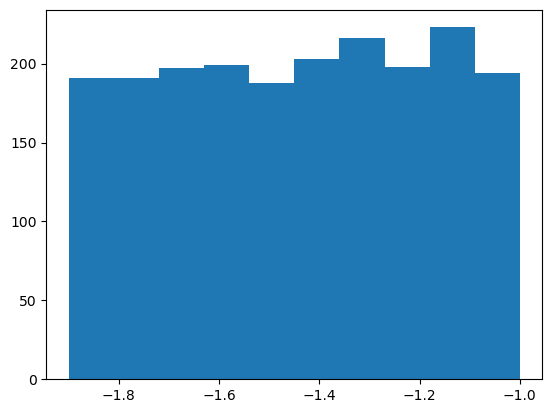

In [161]:
mej_list = []
vej_list = []
xlan_list = []

for i in range(len(param_shifted_paper)):
    mej = param_shifted_paper[i][0][0][0]
    vej = param_shifted_paper[i][0][0][1]
    xlan = param_shifted_paper[i][0][0][2]
    mej_list.append(mej)
    vej_list.append(vej)
    xlan_list.append(xlan)

hist = plt.hist(mej_list)

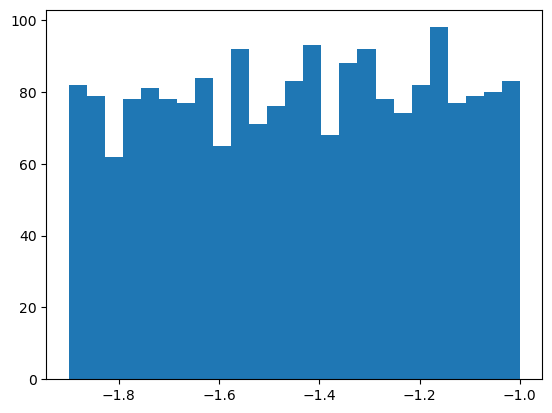

In [162]:
hist = plt.hist(mej_list, bins=25)

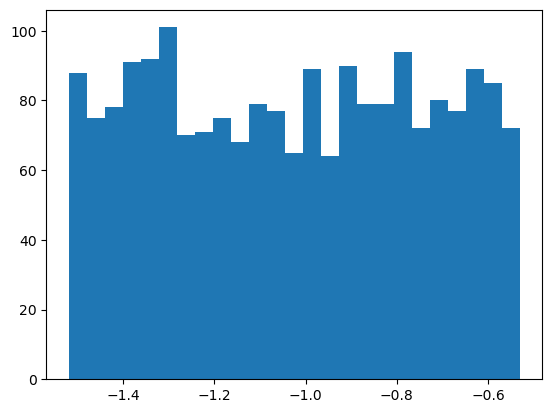

In [163]:
hist = plt.hist(vej_list, bins=25)

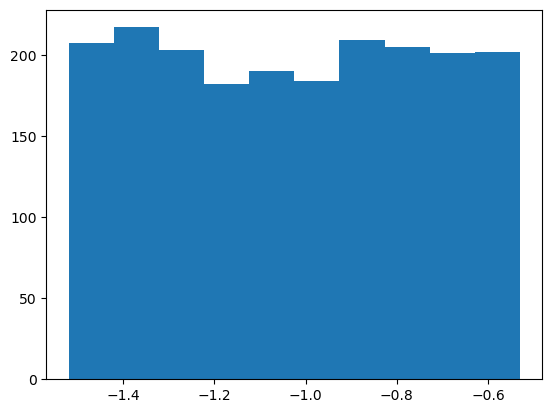

In [164]:
hist = plt.hist(vej_list)

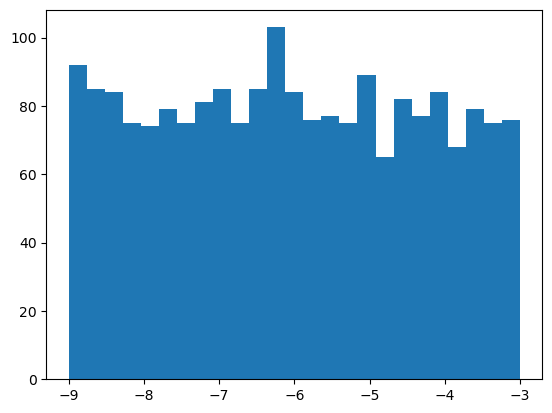

In [165]:
ist = plt.hist(xlan_list, bins=25)

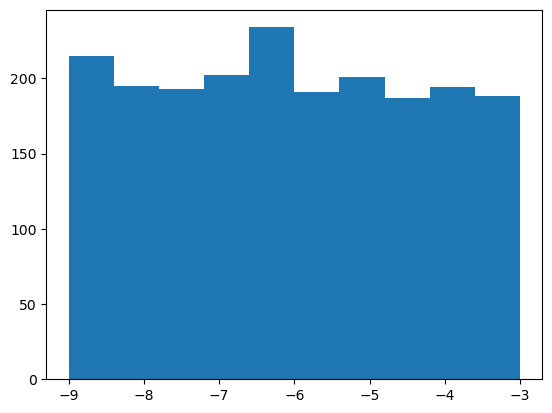

In [166]:
hist = plt.hist(xlan_list)

In [167]:
dist_list = []
shift_list = []

for i in range(len(param_shifted_paper)):
    for j in range(0, 50):
        dist = param_shifted_paper[i][j][0][4]
        shift = param_shifted_paper[i][j][0][3]
        dist_list.append(dist)
        shift_list.append(shift)

In [168]:
print(param_shifted_paper[0][20][0][3])

tensor(4.1619)


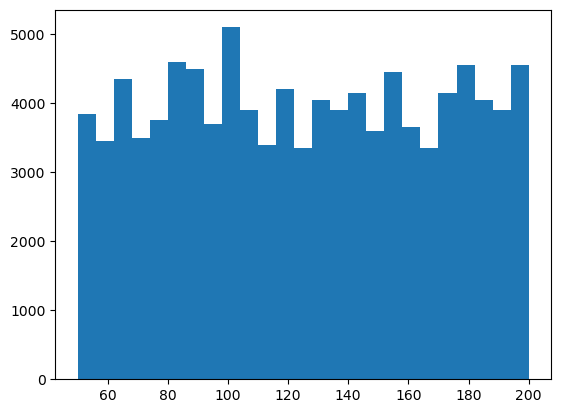

In [169]:
hist = plt.hist(dist_list, bins = 25)

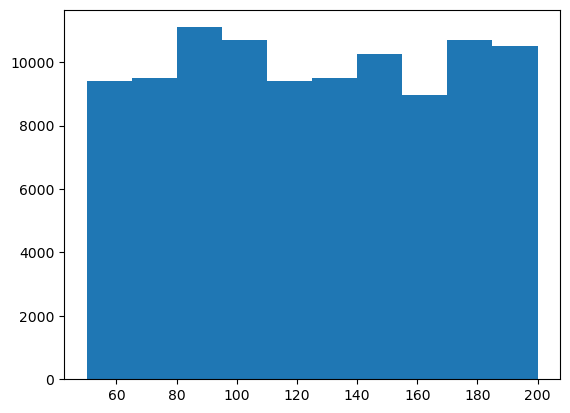

In [170]:
hist = plt.hist(dist_list)


In [171]:
param_shifted_paper[0]

tensor([[[-1.8485e+00, -1.3706e+00, -5.1858e+00, -5.1853e-01,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  2.9352e-01,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  5.3890e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  7.5199e-01,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  3.5013e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  5.6841e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  5.4891e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  4.7594e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00, -2.2589e-01,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  4.0730e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  4.4355e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  4.4690e+00,  1.6834e+02]],

        [[-1.8485e+00, -1.3706e+00, -5.1858e+00,  2.6330e+00,  1

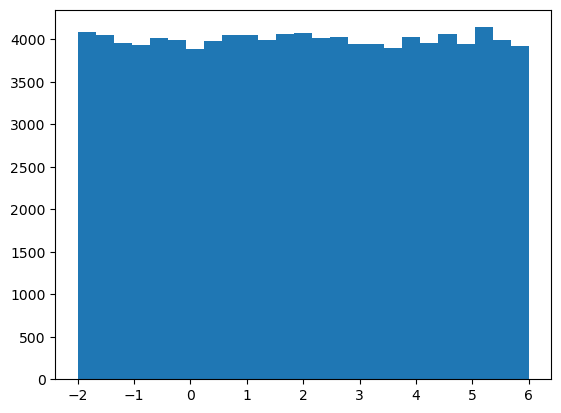

In [172]:
hist = plt.hist(shift_list, bins=25)

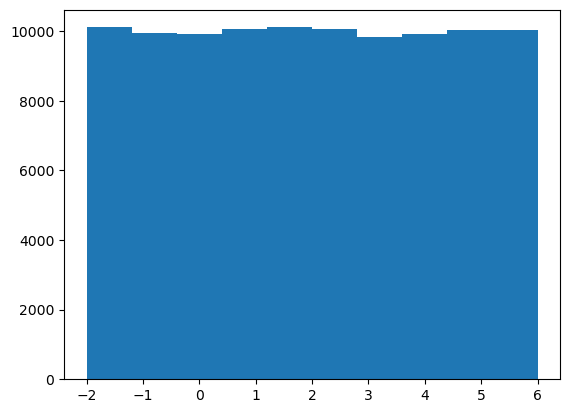

In [173]:
hist = plt.hist(shift_list)

## Light Curve Graphs

Some plotting codes for visualizing the light curves from the .csv files -- SKIP FOR NOW

In [174]:

fixed_colors = ['seagreen', 'crimson', 'blue']
varied_colors = ['mediumaquamarine', 'salmon', 'skyblue']
label_list = ['g band', 'r band', 'i band']
bands = ['ztfg', 'ztfr', 'ztfi']

def varied_fixed_plot(varied_df, fixed_df, sim_id, xlim_min=None, xlim_max=None, title = False, bands=bands):
    varied_data = varied_df.loc[varied_df['sim_id'] == sim_id]
    fixed_data = fixed_df.loc[fixed_df['sim_id'] == sim_id]
    if 'mej' in varied_data.columns:
        mej = varied_data.iloc[0, varied_data.columns.get_loc('mej')]
    if 'vej' in varied_data.columns:
        vej = varied_data.iloc[0, varied_data.columns.get_loc('vej')]
    if 'xlan' in varied_data.columns:
        xlan = varied_data.iloc[0, varied_data.columns.get_loc('xlan')]
    fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(7,7))
    for i in range(len(bands)):
        axs[i].scatter(fixed_data['t'], fixed_data[bands[i]], label = 'fixed, ' + label_list[i] , color = fixed_colors[i], s = 10)
        axs[i].scatter(varied_data['t'], varied_data[bands[i]], label = 'shifted, ' + label_list[i], color = varied_colors[i], s = 10)
        plt.gca().invert_yaxis()
        axs[i].legend()
        if (xlim_min != None) & (xlim_max != None):
            plt.xlim(xlim_min, xlim_max)
    fig.supxlabel('Time (Days)')
    fig.supylabel('Magnitude')
    if title == True:
        if ('vej' in varied_data.columns) and ('mej' in varied_data.columns):
            fig.suptitle('Light Curve for $\log_{{10}}(M_{{ej}})$: {:.2f}, $\log_{{10}}(V_{{ej}})$: {:.2f}, \n$\log_{{10}}(X_{{lan}})$: {:.2f}'.format(mej, vej, xlan), 
                         fontsize = 15)
    else:
        pass
    if 'shift' in varied_data.columns:
        shift = varied_data.iloc[0, varied_data.columns.get_loc('shift')]
    if 'distance' in varied_data.columns:
        distance = varied_data.iloc[0, varied_data.columns.get_loc('distance')]
    print(shift, distance)
    plt.show()

0.2935153488333686 168.34493357212318


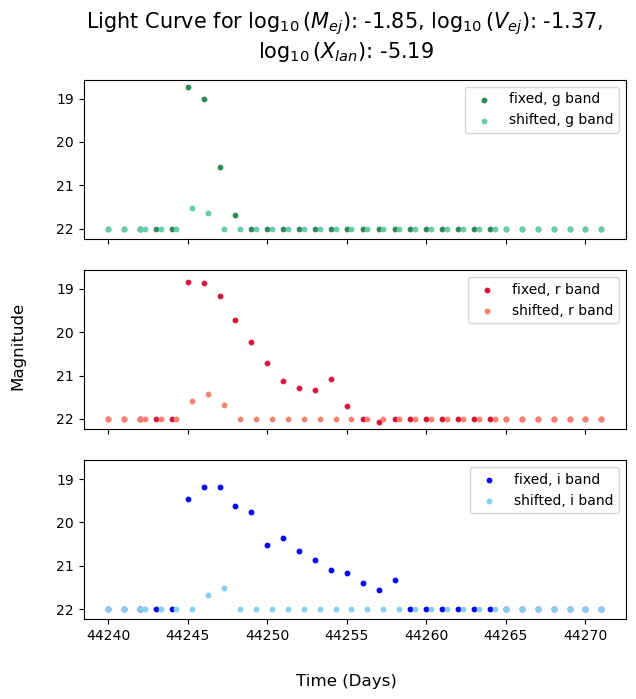

In [175]:
varied_fixed_plot(df_varied, df_fixed, 1,title = True)

# Similarity Embedding

In [176]:
# puts the neural network on the gpu
# similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5).to(device)
# num_dim = 7
# load the weights 

similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5).to(device)
num_dim = 7

SAVEPATH = '/home/mehul/summer2025/Kilo/weights/similarity_embedding.pth'
similarity_embedding.load_state_dict(torch.load(SAVEPATH, map_location=device))

# optimizes
optimizer = optim.Adam(similarity_embedding.parameters(), lr=2.747064325271709e-05)

# sets learning rate steps
scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5) #constant lr
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3) #one cycle - increase and then decrease
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 15])

/tmp/ipykernel_2718/934125866.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  similarity_embedding.load_state_dict(torch.load(SAVEPATH, map_location=device))


In [177]:
# check if data is the right shape for similarity embedding

for var_inj_se, fix_inj_se, var_data_se, fix_data_se in train_data_loader_paper:
    var_inj_se = var_inj_se.reshape((-1,)+var_inj_se.shape[2:])
    fix_inj_se = fix_inj_se.reshape((-1,)+fix_inj_se.shape[2:])
    var_data_se = var_data_se.reshape((-1,)+var_data_se.shape[2:])
    fix_data_se = fix_data_se.reshape((-1,)+fix_data_se.shape[2:])
    break
var_inj_se.shape, var_data_se.shape, fix_inj_se.shape, fix_data_se.shape

(torch.Size([2500, 1, 5]),
 torch.Size([2500, 3, 33]),
 torch.Size([2500, 1, 5]),
 torch.Size([2500, 3, 33]))

In [178]:
# checking the shapes

embed, rep = similarity_embedding(var_data_se)
embed.shape, rep.shape

(torch.Size([2500, 5]), torch.Size([2500, 7]))

In [179]:
# embed the data and calculate the loss for one example to check for bugs

emb_aug, rep_aug = similarity_embedding(var_data_se)
emb_orig, rep_orig = similarity_embedding(fix_data_se)
vicreg_loss(emb_aug, emb_orig)

(tensor(0.0668, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0359, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>))

In [180]:
# print neural network parameters that require gradients and sum parameters

sum_param=0
for name, param in similarity_embedding.named_parameters():
    if param.requires_grad:
        print(name)
        print(param.numel())
        sum_param+=param.numel()
print(sum_param)

layer_norm.weight
363
layer_norm.bias
363
layers_f.conv1.weight
1344
layers_f.bn1.weight
64
layers_f.bn1.bias
64
layers_f.residual_layers.0.0.conv1.weight
20480
layers_f.residual_layers.0.0.bn1.weight
64
layers_f.residual_layers.0.0.bn1.bias
64
layers_f.residual_layers.0.0.conv2.weight
20480
layers_f.residual_layers.0.0.bn2.weight
64
layers_f.residual_layers.0.0.bn2.bias
64
layers_f.residual_layers.0.1.conv1.weight
20480
layers_f.residual_layers.0.1.bn1.weight
64
layers_f.residual_layers.0.1.bn1.bias
64
layers_f.residual_layers.0.1.conv2.weight
20480
layers_f.residual_layers.0.1.bn2.weight
64
layers_f.residual_layers.0.1.bn2.bias
64
layers_f.residual_layers.1.0.conv1.weight
40960
layers_f.residual_layers.1.0.bn1.weight
128
layers_f.residual_layers.1.0.bn1.bias
128
layers_f.residual_layers.1.0.conv2.weight
81920
layers_f.residual_layers.1.0.bn2.weight
128
layers_f.residual_layers.1.0.bn2.bias
128
layers_f.residual_layers.1.0.downsample.0.weight
8192
layers_f.residual_layers.1.0.downsamp

In [181]:
# write to tensorboard for data visualization

writer = SummaryWriter("torchlogs/")
model = similarity_embedding
writer.add_graph(model, var_data_se)
writer.close()

In [182]:
%%time
# training the neural network for many epochs

epoch_number = 0
EPOCHS = 50

sim_val_loss = []
sim_train_loss = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    if epoch_number < 10:
    # set the vicreg weights
        wt_repr, wt_cov, wt_std = (1, 1, 1) #Change the weights as needed for a first few starting epochs
        print(f"VicReg wts: {wt_repr} {wt_cov} {wt_std}")
    else:
        wt_repr, wt_cov, wt_std = (1, 1, 1)
        print(f"VicReg wts: {wt_repr} {wt_cov} {wt_std}")
    # Gradient tracking
    similarity_embedding.train(True)
    avg_train_loss = train_one_epoch_se(epoch_number, writer, train_data_loader_paper,
                                        similarity_embedding, optimizer, vicreg_loss, verbose=True,
                                        wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_train_loss.append(avg_train_loss)
    
    # no gradient tracking, for validation
    similarity_embedding.train(False)
    similarity_embedding.eval()
    avg_val_loss = val_one_epoch_se(epoch_number, writer, val_data_loader_paper,
                                    similarity_embedding, vicreg_loss,
                                    wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_val_loss.append(avg_val_loss)
    
    print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1

    scheduler.step()


EPOCH 1:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.0488
Last 0.03; 0.01; 0.01
 Avg. train loss/batch after 20 batches = 0.0424
Last 0.04; 0.01; 0.00
 Avg. train loss/batch after 30 batches = 0.0400
Last 0.04; 0.01; 0.00
Train/Val Sim Loss after epoch: 0.0400/0.0520
EPOCH 2:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.0388
Last 0.04; 0.01; 0.00
 Avg. train loss/batch after 20 batches = 0.0432
Last 0.03; 0.00; 0.00
 Avg. train loss/batch after 30 batches = 0.0362
Last 0.03; 0.00; 0.00
Train/Val Sim Loss after epoch: 0.0362/0.0327
EPOCH 3:
VicReg wts: 1 1 1
 Avg. train loss/batch after 10 batches = 0.0375
Last 0.03; 0.00; 0.00


KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

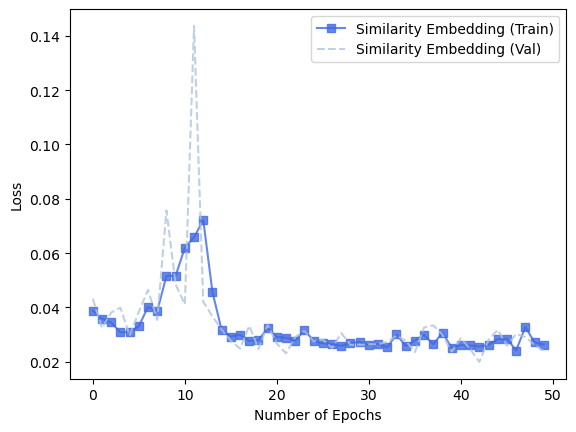

In [99]:
# plot the train/val loss 

epoch_list = range(0,len(sim_train_loss))
plt.plot(epoch_list, sim_train_loss, label = 'Similarity Embedding (Train)', color = 'royalblue', alpha = 0.8, marker = 's')
plt.plot(epoch_list, sim_val_loss, label = 'Similarity Embedding (Val)', color = 'lightsteelblue', alpha=0.8, linestyle="dashed")
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

## Saving Embedding Weights

In [75]:
# save the embedded weights (input your save path)

SAVEPATH = '/home/mehul/summer2025/Kilo/weights/similarity_embedding.pth'
torch.save(similarity_embedding.state_dict(), SAVEPATH)

# Loading Embedding Weights

If you do not want to retrain the embedding, just load the pretrained weights here: 

In [27]:
# load the weights 

similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=5).to(device)
num_dim = 7

SAVEPATH = '/home/mehul/summer2025/Kilo/weights/similarity_embedding.pth'
similarity_embedding.load_state_dict(torch.load(SAVEPATH, map_location=device))

/tmp/ipykernel_1313/235448904.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  similarity_embedding.load_state_dict(torch.load(SAVEPATH, map_location=device))


<All keys matched successfully>

# Visualizing the embedding for all test cases

In [190]:
similarity_embedding.train(False)
data_loader = test_data_loader_paper

similarity_outputs_1 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1) and (shift_test[0][0][0] > -1.25)):
        continue
    if not ((shift_test[0][0][1] < -0.5) and (shift_test[0][0][1] > -0.75)):
        continue
    if not ((shift_test[0][0][2] < -3) and (shift_test[0][0][2] > -4.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_1.append(similarity_output)

similarity_outputs_2 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.25) and (shift_test[0][0][0] > -1.5)):
        continue
    if not ((shift_test[0][0][1] < -0.75) and (shift_test[0][0][1] > -1)):
        continue
    if not ((shift_test[0][0][2] < -4.5) and (shift_test[0][0][2] > -6)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_2.append(similarity_output)

similarity_outputs_3 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.5) and (shift_test[0][0][0] > -1.75)):
        continue
    if not ((shift_test[0][0][1] < -1) and (shift_test[0][0][1] > -1.25)):
        continue
    if not ((shift_test[0][0][2] < -6) and (shift_test[0][0][2] > -7.5)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_3.append(similarity_output)

similarity_outputs_4 = []

for idx, (_, shift_test, data_test, data_test_orig) in enumerate(data_loader):
    _ = _.reshape((-1,)+_.shape[2:])
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    data_test_orig = data_test_orig.reshape((-1,)+data_test_orig.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if not ((shift_test[0][0][0] < -1.75) and (shift_test[0][0][0] > -2.5)):
        continue
    if not ((shift_test[0][0][1] < -1.25) and (shift_test[0][0][1] > -1.55)):
        continue
    if not ((shift_test[0][0][2] < -7.5) and (shift_test[0][0][2] > -9)):
        continue
    with torch.no_grad():
        _, similarity_output = similarity_embedding(data_test)
    similarity_outputs_4.append(similarity_output)



In [191]:
similarity_outputs_1 = torch.stack(similarity_outputs_1)
similarity_outputs_2 = torch.stack(similarity_outputs_2)
similarity_outputs_3 = torch.stack(similarity_outputs_3)
similarity_outputs_4 = torch.stack(similarity_outputs_4)

In [192]:
similarity_outputs_1.shape, similarity_outputs_2.shape, similarity_outputs_3.shape, similarity_outputs_4.shape

(torch.Size([6, 50, 7]),
 torch.Size([4, 50, 7]),
 torch.Size([1, 50, 7]),
 torch.Size([1, 50, 7]))

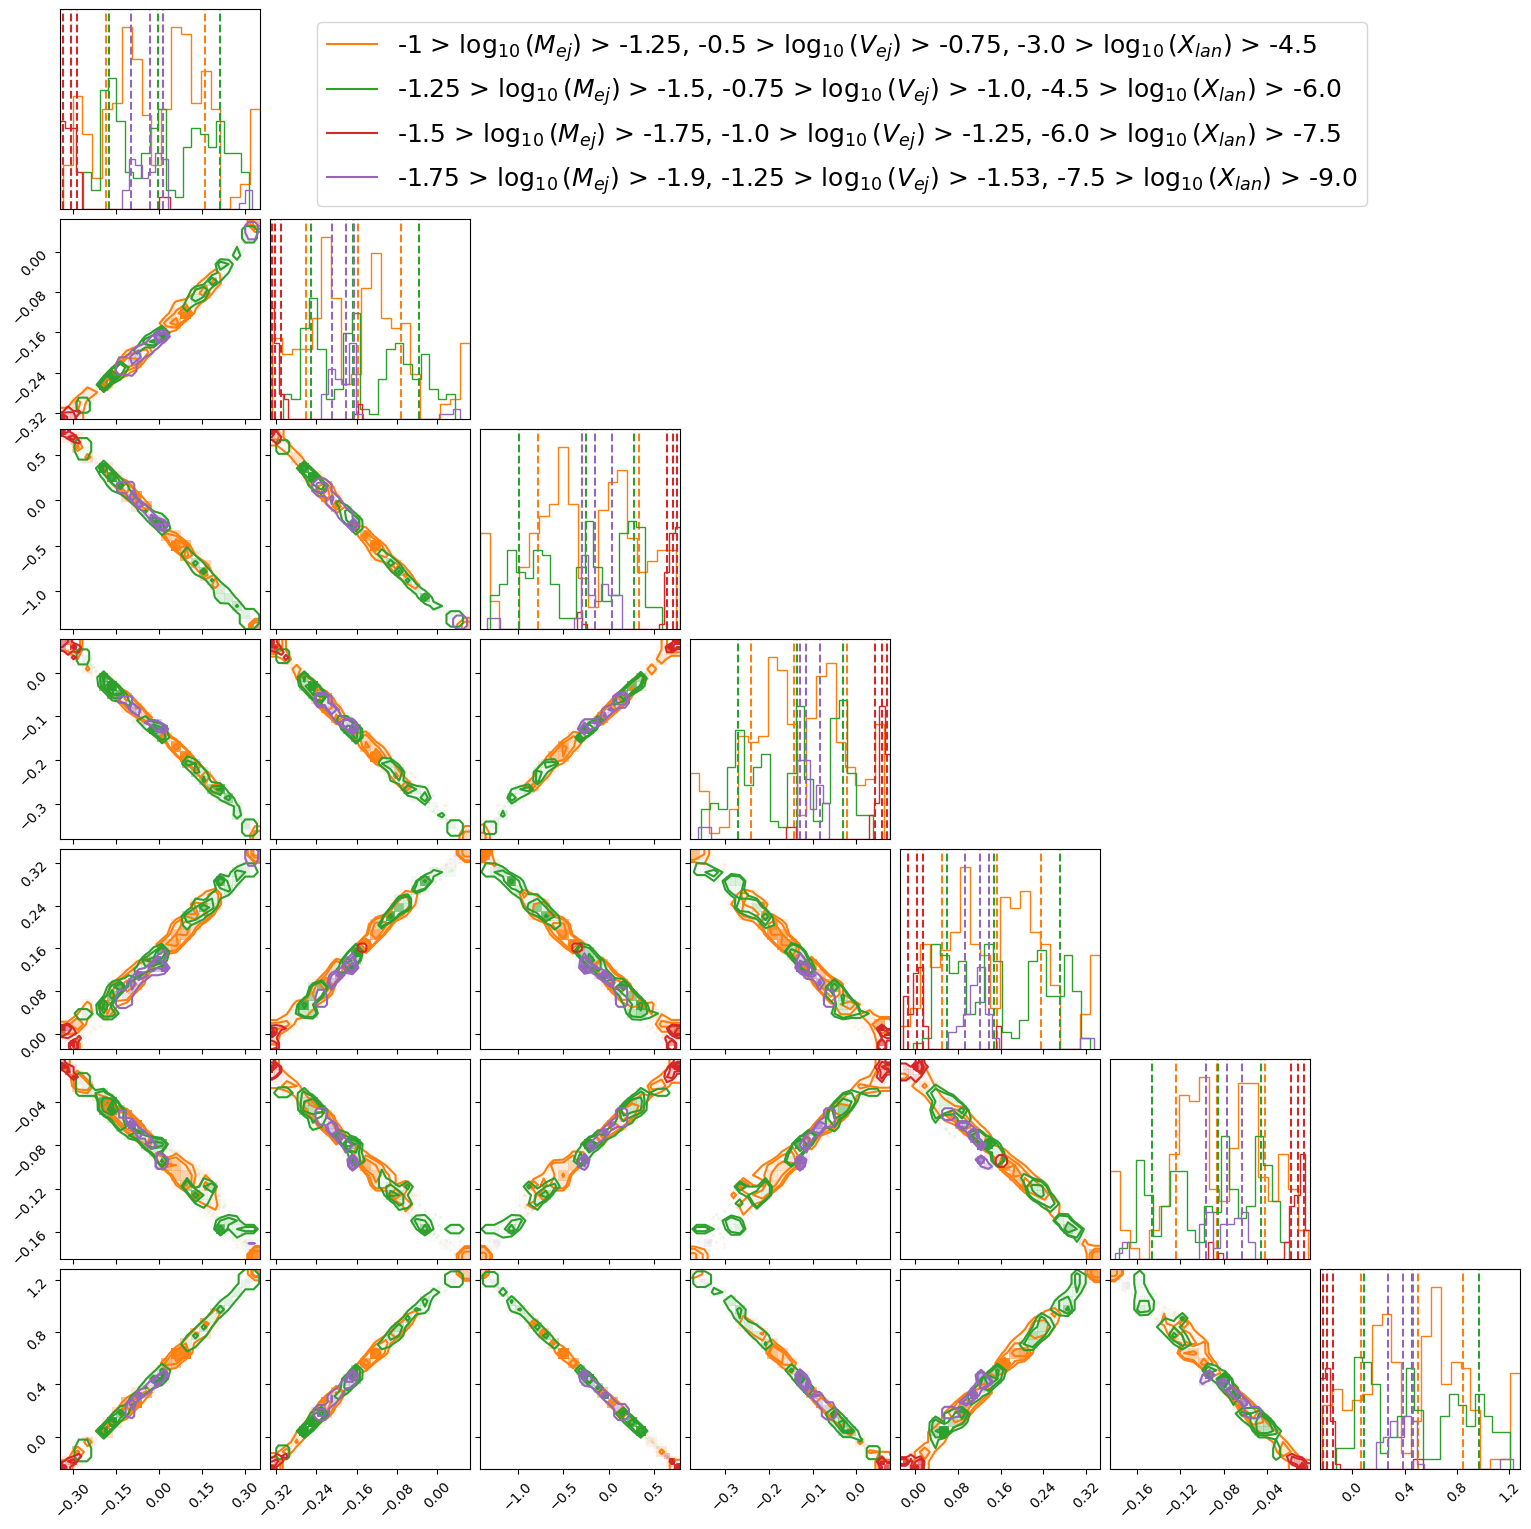

In [193]:
figure = corner.corner(
    similarity_outputs_1.cpu().numpy().reshape((similarity_outputs_1.shape[0]*similarity_outputs_1.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], color="C1"#, range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)
c1_line = mlines.Line2D([], [], color='C1', 
                            label='-1 > $\log_{{10}}(M_{{ej}})$ > -1.25, -0.5 > $\log_{{10}}(V_{{ej}})$ > -0.75, -3.0 > $\log_{{10}}(X_{{lan}})$ > -4.5')

figure = corner.corner(
    similarity_outputs_2.cpu().numpy().reshape((similarity_outputs_2.shape[0]*similarity_outputs_2.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, 
    color="C2", # range = [[-1.2,-0.8], [-1.2,-0.8], [-1.2,-0.8]]
)
c2_line = mlines.Line2D([], [], color='C2', 
                            label='-1.25 > $\log_{{10}}(M_{{ej}})$ > -1.5, -0.75 > $\log_{{10}}(V_{{ej}})$ > -1.0, -4.5 > $\log_{{10}}(X_{{lan}})$ > -6.0')

figure = corner.corner(
    similarity_outputs_3.cpu().numpy().reshape((similarity_outputs_3.shape[0]*similarity_outputs_3.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C3"
)
c3_line = mlines.Line2D([], [], color='C3', 
                            label='-1.5 > $\log_{{10}}(M_{{ej}})$ > -1.75, -1.0 > $\log_{{10}}(V_{{ej}})$ > -1.25, -6.0 > $\log_{{10}}(X_{{lan}})$ > -7.5')

figure = corner.corner(
    similarity_outputs_4.cpu().numpy().reshape((similarity_outputs_4.shape[0]*similarity_outputs_4.shape[1], num_dim)),
    quantiles=[0.16, 0.5, 0.84], fig=figure, color="C4"
)
c4_line = mlines.Line2D([], [], color='C4', 
                            label='-1.75 > $\log_{{10}}(M_{{ej}})$ > -1.9, -1.25 > $\log_{{10}}(V_{{ej}})$ > -1.53, -7.5 > $\log_{{10}}(X_{{lan}})$ > -9.0')

plt.legend(handles=
           [c1_line, c2_line, c3_line, c4_line],
           bbox_to_anchor=(0.3, 7.3),
           fontsize = 18
          )

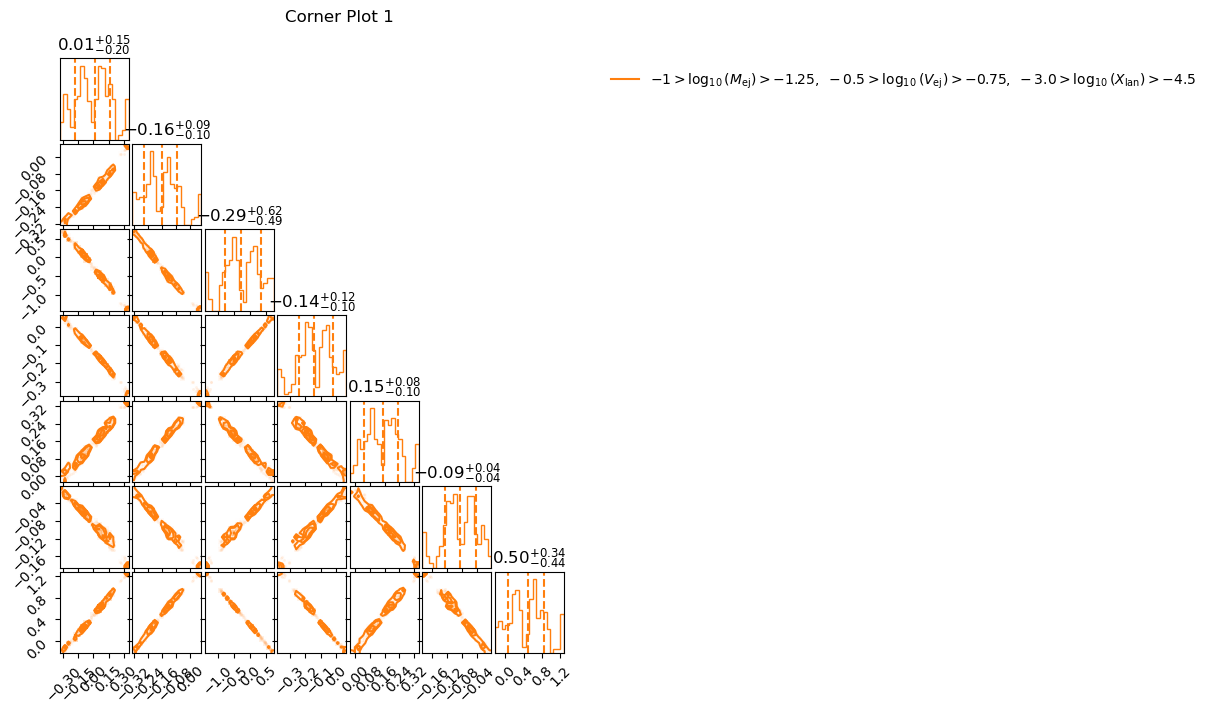

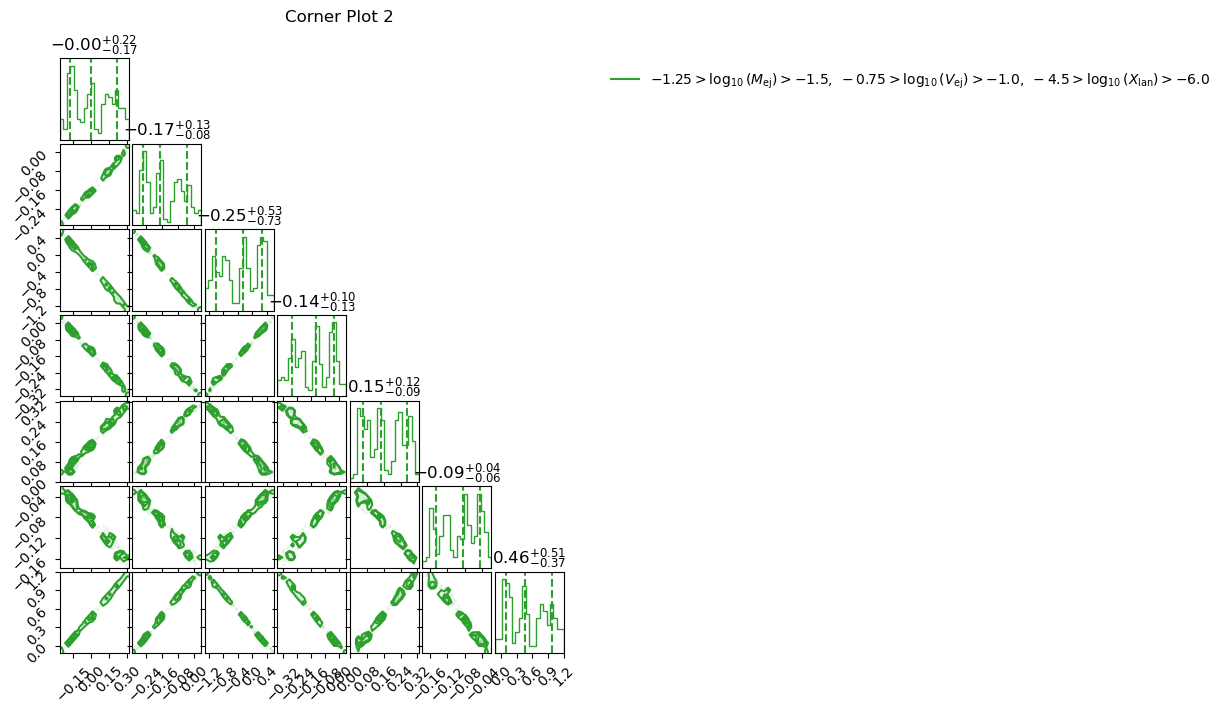

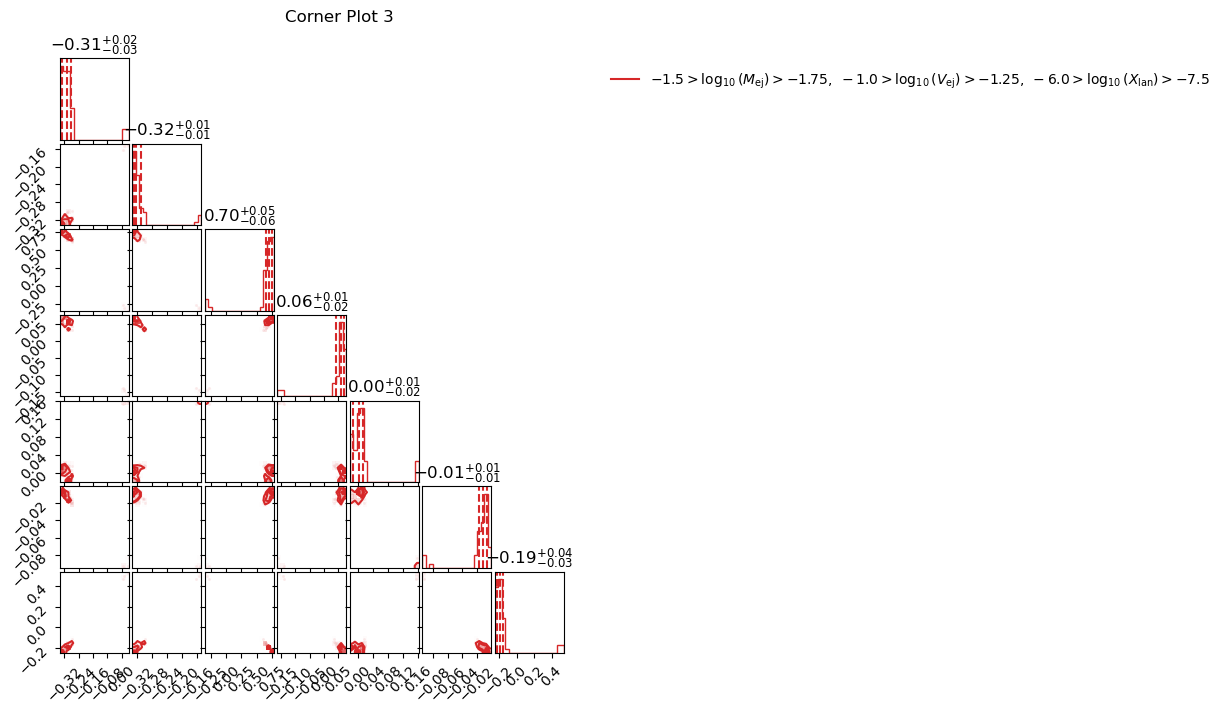

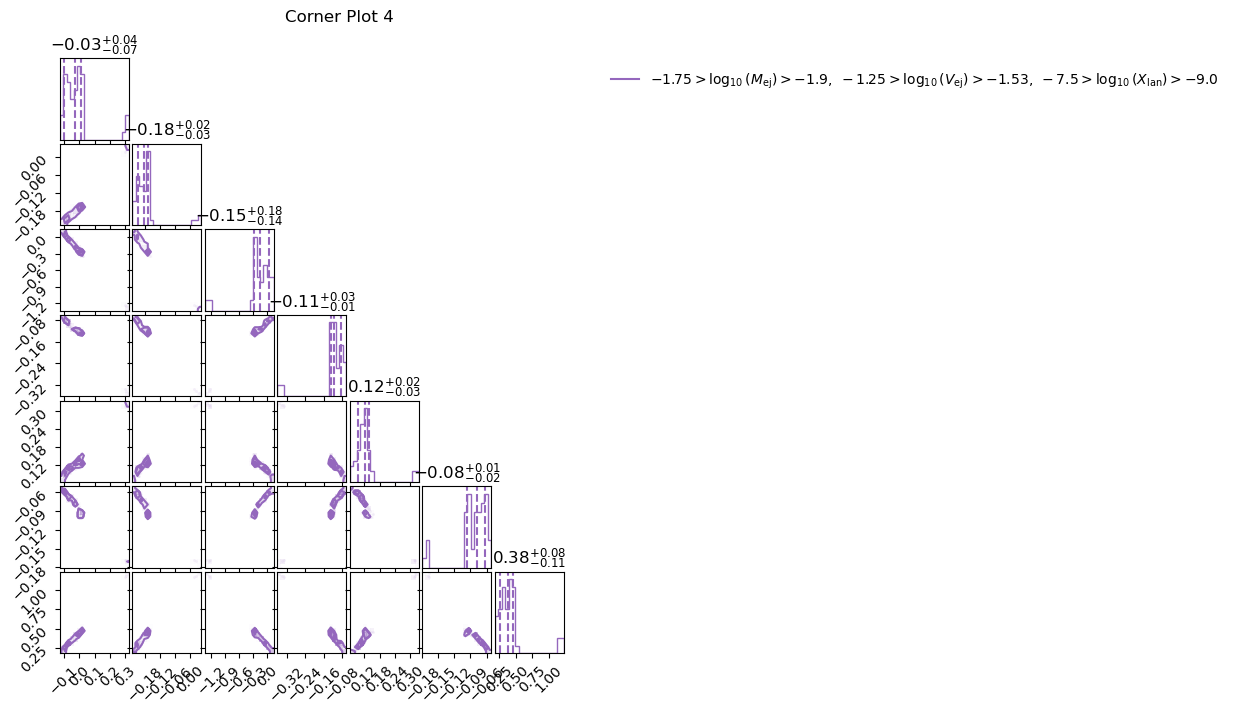

In [194]:
import matplotlib.pyplot as plt
import corner
import matplotlib.lines as mlines

datasets = [
    similarity_outputs_1,
    similarity_outputs_2,
    similarity_outputs_3,
    similarity_outputs_4,
]
colors = ["C1", "C2", "C3", "C4"]
labels = [
    r"$-1 > \log_{10}(M_{\rm ej}) > -1.25,\;-0.5 > \log_{10}(V_{\rm ej}) > -0.75,\;-3.0 > \log_{10}(X_{\rm lan}) > -4.5$",
    r"$-1.25 > \log_{10}(M_{\rm ej}) > -1.5,\;-0.75 > \log_{10}(V_{\rm ej}) > -1.0,\;-4.5 > \log_{10}(X_{\rm lan}) > -6.0$",
    r"$-1.5 > \log_{10}(M_{\rm ej}) > -1.75,\;-1.0 > \log_{10}(V_{\rm ej}) > -1.25,\;-6.0 > \log_{10}(X_{\rm lan}) > -7.5$",
    r"$-1.75 > \log_{10}(M_{\rm ej}) > -1.9,\;-1.25 > \log_{10}(V_{\rm ej}) > -1.53,\;-7.5 > \log_{10}(X_{\rm lan}) > -9.0$",
]

for idx, (data, color, label) in enumerate(zip(datasets, colors, labels), start=1):
    arr = data.cpu().numpy().reshape(-1, num_dim)

    # 1) make a new, reasonably‐sized figure
    fig = plt.figure(figsize=(7, 7))

    # 2) draw the corner plot into it
    corner.corner(
        arr,
        fig=fig,
        quantiles=[0.16, 0.5, 0.84],
        color=color,
        show_titles=True,
        title_fmt=".2f",
    )

    # 3) create a single Line2D for the legend
    line = mlines.Line2D([], [], color=color, label=label)

    # 4) shrink the plotting area to make room for the legend on the right
    #    the [left, bottom, right, top] rectangle keeps most of the figure
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.82, top=0.95)

    # 5) place the legend inside that right margin
    fig.legend(
        handles=[line],
        loc="upper left",
        bbox_to_anchor=(0.87, 0.95),
        fontsize=10,
        frameon=False,
    )

    plt.suptitle(f"Corner Plot {idx}", y=1.02)
    plt.show()




# Normalizing Flow Training Data

### Varied Data

In [ ]:
varied_normflow_dict = {}

In [ ]:
# get the varied data

norm_path = '/nobackup/users/mmdesai/lowcflowdata'
num_sims = 25000

normflow_num_lc_list = [25000, 25000, 25000, 24843, 25000, 24917, 25000, 25000, 24706, 25000]

for i in range(3, 10):
    # get the names of each file
    file_names = get_names(norm_path, 'varied', i, normflow_num_lc_list[i])
    # open the files as dataframes
    varied_normflow_dict['varied_normflow_data_{}'.format(i)] = json_to_df(file_names, normflow_num_lc_list[i])
    # pad the data
    varied_normflow_dict['varied_normflow_data_{}'.format(i)] = pad_all_dfs(varied_normflow_dict['varied_normflow_data_{}'.format(i)])

In [ ]:
varied_normflow_dict['varied_normflow_data_0'][0]

In [ ]:
for i in range(0, 50):
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfg'], color = 'g')
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfr'], color = 'r')
    plt.scatter(varied_normflow_dict['varied_normflow_data_0'][i]['t'], varied_normflow_dict['varied_normflow_data_0'][i]['ztfi'], color = 'c')
plt.gca().invert_yaxis()
plt.xlabel('Time (days)')
plt.ylabel('Magnitude')

In [ ]:
# injection files

varied_normflow_inj_dict = {}
inj_path_normflow = '/nobackup/users/mmdesai/final_injections/'

for i in range(0, 10):
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)] = pd.DataFrame()
    varied_params = open_json('injection_normflow_varied_{}.json'.format(i), inj_path_normflow)
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['mej'] = varied_params['injections']['content']['log10_mej']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['vej'] = varied_params['injections']['content']['log10_vej']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['xlan'] = varied_params['injections']['content']['log10_Xlan']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['shift'] = varied_params['injections']['content']['timeshift']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['distance'] = varied_params['injections']['content']['luminosity_distance']
    varied_normflow_inj_dict['varied_inj_df{}'.format(i)]['sim_id'] = varied_params['injections']['content']['simulation_id']

In [ ]:
varied_normflow_inj_dict['varied_inj_df0']

In [ ]:
# concatenate dataframe lists

all_varied_data_list_flow = [0] * 10

for i in range(0, 10):
    all_varied_data_list_flow[i] = pd.concat(varied_normflow_dict['varied_normflow_data_{}'.format(i)])

In [ ]:
# merge with injection parameters

all_varied_datawparams_list_flow = [0] * 10

for i in range(0, 10):
    all_varied_datawparams_list_flow[i] = all_varied_data_list_flow[i].merge(varied_normflow_inj_dict['varied_inj_df{}'.format(i)], on = 'sim_id')
    # save as csv file
    all_varied_datawparams_list_flow[i].to_csv('/nobackup/users/mmdesai/final_csv/flow_varied_lowc_{}.csv'.format(i), index = False)

In [ ]:
all_varied_datawparams_list_flow[0]

# Data Processing


In [37]:
import os
import glob
import numpy as np
import pandas as pd
import gc

# — your helper functions must already be imported:
#    json_to_df(file_name, dir_path, detection_limit, bands)
#    pad_all_dfs(df_list, t_min, t_max, step, data_filler, bands)

# 0) USER PARAMETERS
dir_path        = "/home/mehul/summer2025/Kilo/data/varied3/"
detection_limit = 22.0
bands           = ['ztfg', 'ztfr', 'ztfi']
chunk_size      = 5000        # how many sims to process per batch
batch_size      = 50          # sims per batch for batch_id
output_csv      = "/home/mehul/summer2025/Kilo/csv files/norm_flow_data_3.csv"

# 1) GATHER ALL JSON PATHS
file_list = sorted(glob.glob(os.path.join(dir_path, "test_*.json")))

# 2) DETERMINE GLOBAL TIME GRID
raw_min, raw_max = np.inf, -np.inf
for fp in file_list:
    df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
    raw_min = min(raw_min, df['t'].min())
    raw_max = max(raw_max, df['t'].max())

step  = 1.0
t_min = np.floor(raw_min)
t_max = np.ceil(raw_max) + step

# 3) REMOVE OLD CSV
if os.path.exists(output_csv):
    os.remove(output_csv)

# 4) PROCESS IN CHUNKS
for start in range(0, len(file_list), chunk_size):
    chunk_files = file_list[start : start + chunk_size]
    df_list     = []

    # 4a) LOAD & ANNOTATE
    for sim_idx, fp in enumerate(chunk_files, start=start):
        df = json_to_df(os.path.basename(fp), dir_path, detection_limit, bands)
        df['sim_id']         = sim_idx
        df['num_detections'] = (df[bands] < detection_limit).sum().sum()
        df_list.append(df)

    # 4b) PAD TO UNIFORM LENGTH
    padded = pad_all_dfs(df_list, t_min, t_max, step, detection_limit, bands)

    # 4c) ASSIGN batch_id
    for idx, df in enumerate(padded, start=start):
        df['batch_id'] = idx // batch_size

    # 4d) CONCAT & APPEND TO CSV
    chunk_df = pd.concat(padded, ignore_index=True)
    chunk_df.to_csv(
        output_csv,
        mode='a',
        index=False,
        header=not os.path.exists(output_csv)
    )

    # 4e) CLEAN UP
    del df_list, padded, chunk_df
    gc.collect()

# 5) (optional) READ BACK FULL DATAFRAME
df_all = pd.read_csv(output_csv)
print("Final table shape:", df_all.shape)
print("Time spans:", df_all['t'].min(), "→", df_all['t'].max())
print("Unique batch_ids:", sorted(df_all['batch_id'].unique()))


100%|██████████| 5000/5000 [00:05<00:00, 891.39it/s]


Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.in

In [ ]:
output_csv = "/home/mehul/summer2025/Kilo/csv files/norm_flow_data_3.csv"

df_all = pd.read_csv(output_csv)
print("Final table shape:", df_all.shape)
print("Time spans:", df_all['t'].min(), "→", df_all['t'].max())
print("Unique batch_ids:", sorted(df_all['batch_id'].unique()))

Final table shape: (3300000, 7)
Time spans: 44240.0 → 44271.0
Unique batch_ids: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.in

In [41]:
sim_id = 10  # change this to the sim_id you want to inspect
df_sim = df_all[df_all['sim_id'] == sim_id]
print(f"Data for sim_id {sim_id}:\n", df_sim)

Data for sim_id 10:
                 t       ztfg       ztfr       ztfi  sim_id  num_detections  \
330  44240.000000  22.000000  22.000000  22.000000      10              25   
331  44241.000000  22.000000  22.000000  22.000000      10              25   
332  44242.000000  22.000000  22.000000  22.000000      10              25   
333  44242.150933  22.000000  22.000000  22.000000      10              25   
334  44243.150933  22.000000  22.000000  22.000000      10              25   
335  44244.150933  22.000000  22.000000  22.000000      10              25   
336  44245.150933  19.814955  20.223147  20.863793      10              25   
337  44246.150933  19.436791  19.695569  19.691406      10              25   
338  44247.150933  19.871738  19.363322  19.758243      10              25   
339  44248.150933  20.331984  19.342122  19.579213      10              25   
340  44249.150933  21.346809  19.871324  19.492350      10              25   
341  44250.150933  22.000000  20.676483  19

In [42]:
inj_path_simembed = '/home/mehul/summer2025/Kilo/data/varied/'

varied_inj_df = pd.DataFrame()
varied_params = open_json('injection_varied.json', inj_path_simembed)
varied_inj_df['mej'] = varied_params['injections']['content']['log10_mej']
varied_inj_df['vej'] = varied_params['injections']['content']['log10_vej']
varied_inj_df['xlan'] = varied_params['injections']['content']['log10_Xlan']
varied_inj_df['shift'] = varied_params['injections']['content']['timeshift']
varied_inj_df['distance'] = varied_params['injections']['content']['luminosity_distance']
varied_inj_df['sim_id'] = varied_params['injections']['content']['simulation_id']
varied_injections = varied_inj_df

print(varied_injections)

             mej       vej      xlan     shift    distance  sim_id
0      -1.214509 -1.425817 -6.776705  2.043322  132.779316       0
1      -1.214509 -1.425817 -6.776705  0.189563  132.779316       1
2      -1.214509 -1.425817 -6.776705  1.960745  132.779316       2
3      -1.214509 -1.425817 -6.776705  2.425005  132.779316       3
4      -1.214509 -1.425817 -6.776705  5.933915  132.779316       4
...          ...       ...       ...       ...         ...     ...
499995 -1.559325 -1.211819 -3.271324 -1.287060  134.499789  499995
499996 -1.559325 -1.211819 -3.271324  1.873470  134.499789  499996
499997 -1.559325 -1.211819 -3.271324 -0.770210  134.499789  499997
499998 -1.559325 -1.211819 -3.271324  5.949519  134.499789  499998
499999 -1.559325 -1.211819 -3.271324  5.166765  134.499789  499999

[500000 rows x 6 columns]


In [43]:
#extract first 100000 rows of varied_injections
varied_injections = varied_injections.iloc[300000:400000]

#subtract 200000 from sim_id
varied_injections['sim_id'] = varied_injections['sim_id'] - 300000
print(varied_injections)

             mej       vej      xlan     shift    distance  sim_id
300000 -1.275977 -1.438701 -4.297662  4.164239  105.058665       0
300001 -1.275977 -1.438701 -4.297662  5.277449  105.058665       1
300002 -1.275977 -1.438701 -4.297662  1.830647  105.058665       2
300003 -1.275977 -1.438701 -4.297662  5.219805  105.058665       3
300004 -1.275977 -1.438701 -4.297662  0.946906  105.058665       4
...          ...       ...       ...       ...         ...     ...
399995 -1.558393 -1.493038 -4.577450 -1.815309  139.977409   99995
399996 -1.558393 -1.493038 -4.577450  3.956281  139.977409   99996
399997 -1.558393 -1.493038 -4.577450  0.531116  139.977409   99997
399998 -1.558393 -1.493038 -4.577450  3.007966  139.977409   99998
399999 -1.558393 -1.493038 -4.577450  5.432394  139.977409   99999

[100000 rows x 6 columns]


/tmp/ipykernel_2718/3893535507.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  varied_injections['sim_id'] = varied_injections['sim_id'] - 300000


In [44]:
# if your varied_injections DataFrame calls its sim key something else, rename it:
# varied_injections = varied_injections.rename(columns={ 'simulation_id': 'sim_id' })

# select only the columns you care about from injections
inj_cols = ['sim_id', 'mej','vej','xlan','shift','distance']

# merge onto your full light‐curve table
df_final = df_all.merge(
    varied_injections[inj_cols],
    on='sim_id',
    how='left'
)

print("Final shape:", df_final.shape)  # should be (~3 300 000, original_cols+5)


Final shape: (3300000, 12)


In [45]:
desired_order = ['t', 'ztfg', 'ztfr', 'ztfi', 'num_detections', 'mej', 'vej', 'xlan', 'shift', 'distance', 'batch_id', 'sim_id']
df_norm = df_final[desired_order]

In [48]:
data_shifted_flow, param_shifted_flow = test_df_to_tensor(df_norm, 2000, 50)

100%|██████████| 2000/2000 [00:09<00:00, 206.55it/s]


# Load in the Data

ONLY CSV

In [ ]:
data_dir_flow = '/nobackup/users/mmdesai/final_csv/'

In [ ]:
df_flow1 = load_in_data(data_dir_flow, 'flow_varied', 10) 

In [ ]:
df_flow1

In [ ]:
detected_df1 = df_flow1.loc[df_flow1['num_detections'] >= 20]
detected_df1

In [ ]:
# varied

detected_df1 = detected_df1.iloc[:29275950, :12]
add_batch_sim_nums_all(detected_df1)
detected_df1

In [ ]:
matched_df_flow2 = matched(data_dir_flow, 'flow_varied', 'flow_fixed', 10, 20) 

In [ ]:
new_df_flow2 = matched_df_flow2.loc[matched_df_flow2['mej_x'] >= -1.9].copy()
new_df_flow2

In [ ]:
detected_df2 = new_df_flow2.loc[new_df_flow2['num_detections_x'] >= 8]
detected_df2

In [ ]:
# varied

var_df = detected_df2.iloc[:27097950, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

In [ ]:
# fixed

fix_df = detected_df2.iloc[:27097950, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

In [ ]:
matched_df_flow3 = matched(data_dir_flow, 'flow_varied', 'flow_fixed', 20, 30) 

In [ ]:
new_df_flow3 = matched_df_flow3.loc[matched_df_flow3['mej_x'] >= -1.9].copy()
new_df_flow3

In [ ]:
detected_df3 = new_df_flow3.loc[new_df_flow3['num_detections_x'] >= 8]
detected_df3

In [ ]:
# varied

var_df = detected_df3.iloc[:27073750, :12]
var_df.columns = var_df.columns.str.rstrip('_x')
var_df = var_df.drop(columns=['key_1'])
add_batch_sim_nums_all(var_df)
var_df

In [ ]:
# fixed

fix_df = detected_df3.iloc[:27073750, 12:]
fix_df.columns = fix_df.columns.str.rstrip('_y')
add_batch_sim_nums_all(fix_df)
fix_df

In [ ]:
plt.hist(var_df['mej'])

In [ ]:
plt.hist(var_df['vej'])

In [ ]:
plt.hist(var_df['xlan'])

In [ ]:
plt.hist(var_df['distance'])

# Prep for Flow

In [ ]:
# moving the data from csv to tensors on gpu -- Don't run if tensors are already stored and available

num_lc_flow = len(detected_df1['batch_id'].unique())
data_shifted_flow, param_shifted_flow = test_df_to_tensor(detected_df1, num_lc_flow, 50)

In [ ]:
data_shifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_flow4.pt')
data_unshifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_flow4.pt')
param_shifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_flow4.pt')
param_unshifted_flow1 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_flow4.pt')

In [ ]:
data_shifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_flow7.pt')
data_unshifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_flow7.pt')
param_shifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_flow7.pt')
param_unshifted_flow2 = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_flow7.pt')

In [ ]:
data_shifted_flow = torch.stack(data_shifted_flow1 + data_shifted_flow2)
param_shifted_flow = torch.stack(param_shifted_flow1 + param_shifted_flow2)

In [49]:
num_lc_flow = len(data_shifted_flow)
print(num_lc_flow)

2000


In [50]:
data_shifted_flow[0].shape, param_shifted_flow[0].shape

(torch.Size([50, 3, 33]), torch.Size([50, 1, 5]))

In [104]:
class Flow_data(Dataset):
    def __init__(self, data_shifted_flow, param_shifted_flow,num_lc_flow):
        super().__init__()
        self.data_shifted_flow = data_shifted_flow
        self.param_shifted_flow = param_shifted_flow
        self.num_lc_flow = num_lc_flow

    def __len__(self):
        return self.num_lc_flow

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return (
            self.param_shifted_flow[idx].to(device),
            self.data_shifted_flow[idx].to(device),
        )

In [105]:
num_lc_flow = len(data_shifted_test)
test_data_loader_flow = DataLoader(
    Flow_data(data_shifted_test, param_shifted_test, num_lc_flow),
    batch_size=500,
    shuffle=False)

In [52]:
num_lc_flow = 2000
dataset_normflow = Flow_data(data_shifted_flow, param_shifted_flow, num_lc_flow)

# check the dataset shape
t, d = dataset_normflow[4]
t.shape, d.shape

(torch.Size([50, 1, 5]), torch.Size([50, 3, 33]))

In [53]:
# split dataset into training, testing, and validation

train_set_size_flow = int(0.8 * num_lc_flow)    
val_set_size_flow = int(0.1 * num_lc_flow)     
test_set_size_flow = num_lc_flow - train_set_size_flow - val_set_size_flow

train_data_flow, val_data_flow, test_data_flow = torch.utils.data.random_split(
    dataset_normflow, [train_set_size_flow, val_set_size_flow, test_set_size_flow])

In [54]:
# load and shuffle the data

train_data_loader_flow = DataLoader(train_data_flow, batch_size=25, shuffle=True)
val_data_loader_flow = DataLoader(val_data_flow, batch_size=25, shuffle=True)
test_data_loader_flow = DataLoader(test_data_flow, batch_size=1, shuffle=False)

# check lengths
len(train_data_loader_flow), len(test_data_loader_flow), len(val_data_loader_flow)

(64, 200, 8)

In [55]:
# check first instance of data

for var_inj, var_data in train_data_loader_flow:
    var_inj = var_inj.reshape((-1,)+var_inj.shape[2:])
    var_data = var_data.reshape((-1,)+var_data.shape[2:])

    break
var_inj.shape, var_data.shape

(torch.Size([1250, 1, 5]), torch.Size([1250, 3, 33]))

# Histograms

In [56]:
mej_list = []
vej_list = []
xlan_list = []

for i in range(len(param_shifted_flow)):
    mej = param_shifted_flow[i][0][0][0]
    vej = param_shifted_flow[i][0][0][1]
    xlan = param_shifted_flow[i][0][0][2]
    mej_list.append(mej)
    vej_list.append(vej)
    xlan_list.append(xlan)

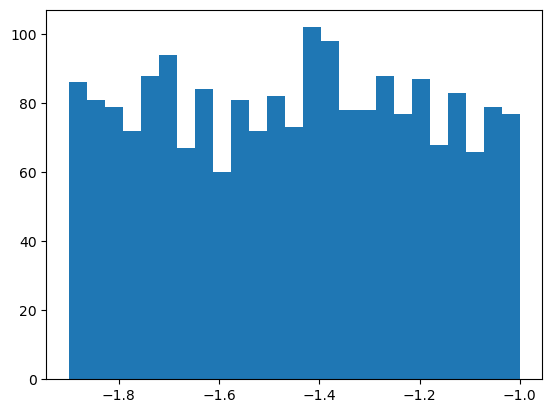

In [57]:
hist = plt.hist(mej_list, bins=25)

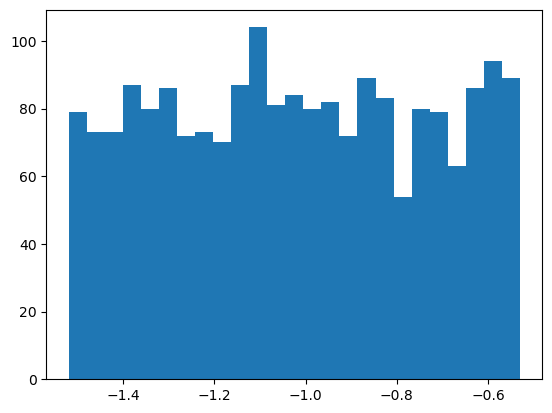

In [58]:
hist = plt.hist(vej_list, bins=25)

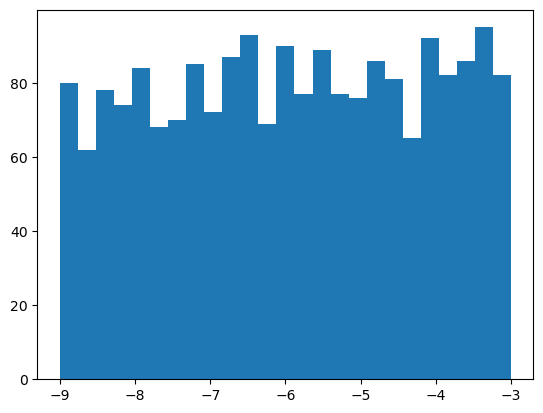

In [59]:
hist = plt.hist(xlan_list, bins=25)

In [60]:
dist_list = []
shift_list = []

for i in range(len(param_shifted_flow)):
    for j in range(0, 50):
        dist = param_shifted_flow[i][j][0][4]
        shift = param_shifted_flow[i][j][0][3]
        dist_list.append(dist)
        shift_list.append(shift)

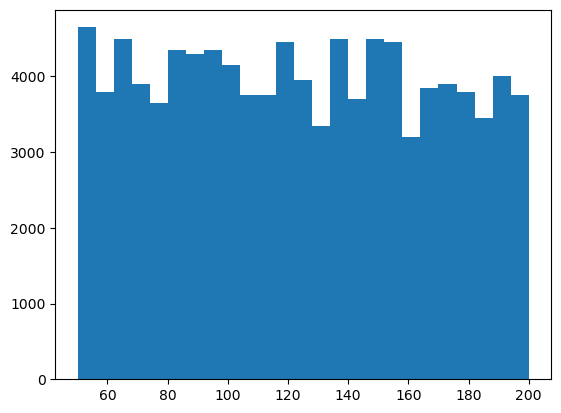

In [61]:
hist = plt.hist(dist_list, bins = 25)

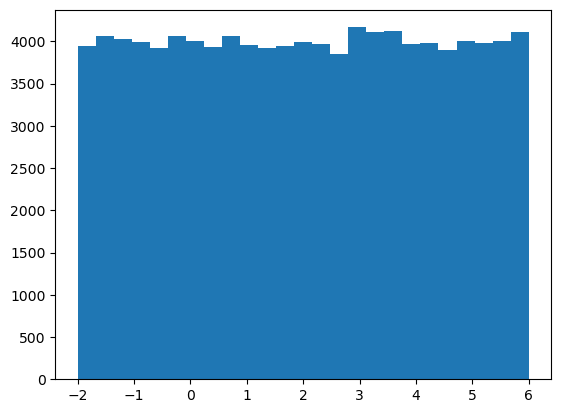

In [62]:
hist = plt.hist(shift_list, bins = 25)

# Partially Freeze the Similarity Embedding

In [63]:
for var_inj_se, var_data_se in train_data_loader_flow:
    var_inj_se = var_inj_se.reshape((-1,)+var_inj_se.shape[2:]).to(device)
    var_data_se = var_data_se.reshape((-1,)+var_data_se.shape[2:]).to(device)
    break

# check shapes
print(var_data_se.shape, var_inj_se.shape)
_, rep = similarity_embedding(var_data_se)  # _.shape = batch_size x 1 x 10, # rep.shape = batch_size x 1 x 2
print(_.shape, rep.shape)
context_features = rep.shape[-1]
print('number of context_features: ', context_features)
print('number of dimensions: ', num_dim)

torch.Size([1250, 3, 33]) torch.Size([1250, 1, 5])
torch.Size([1250, 5]) torch.Size([1250, 7])
number of context_features:  7
number of dimensions:  7


In [ ]:
# define parameters

transform, base_dist, embedding_net = normflow_params(similarity_embedding, 9, 5, 90, context_features=context_features, num_dim=num_dim) 

In [ ]:
flow = Flow(transform, base_dist, embedding_net).to(device=device)

In [66]:
print('Total number of trainable parameters: ', sum(p.numel() for p in flow.parameters() if p.requires_grad))

Total number of trainable parameters:  1204975


In [67]:
for idx, val in enumerate(train_data_loader_flow, 1):
    augmented_shift, augmented_data = val
    augmented_shift = augmented_shift[...,0:3].to(device)
    augmented_shift = augmented_shift.flatten(0, 2).to(device)
    augmented_data = augmented_data.reshape(-1, 3, num_points).to(device)
    print(augmented_shift.shape, augmented_data.shape)
    break

torch.Size([1250, 3]) torch.Size([1250, 3, 33])


In [68]:
similarity_embedding(augmented_data)[0].shape, similarity_embedding(augmented_data)[1].shape

(torch.Size([1250, 5]), torch.Size([1250, 7]))

In [69]:
flow_loss = -flow.log_prob(augmented_shift, context=augmented_data).mean()
flow_loss

tensor(0.7931, device='cuda:0', grad_fn=<NegBackward0>)

# Train and Validate

In [70]:
# optimizer
optimizer = optim.SGD(flow.parameters(), lr=0.0000912, momentum=0.5)
# scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, threshold=0.001)

In [71]:
writer = SummaryWriter()

In [72]:
%%time
# UNCOMMENT AND RUN TO TRAIN FROM SCRATCH

train_loss_list = []
val_loss_list = []

EPOCHS = 50
epoch_number = 0
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    flow.train(True)
    for name, param in flow._embedding_net.named_parameters():
        param.requires_grad = True
    avg_train_loss = train_one_epoch(epoch_number, writer, train_data_loader_flow, flow, optimizer, 2)
    train_loss_list.append(avg_train_loss)
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer, val_data_loader_flow, flow, 2)
    val_loss_list.append(avg_val_loss)
    print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
    epoch_number += 1
    scheduler.step(avg_val_loss)
    for param_group in optimizer.param_groups:
        print("Current LR = {:.3e}".format(param_group['lr']))

EPOCH 1:
 Avg. train loss/batch after 10 batches = 1.3367
 Avg. train loss/batch after 20 batches = 1.1265
 Avg. train loss/batch after 30 batches = 0.9348
 Avg. train loss/batch after 40 batches = 1.2456
 Avg. train loss/batch after 50 batches = 0.8942
 Avg. train loss/batch after 60 batches = 1.0237
 Avg. train loss/batch after 1 batches = 0.7573
 Avg. train loss/batch after 2 batches = 0.6952
 Avg. train loss/batch after 3 batches = 1.2600
 Avg. train loss/batch after 4 batches = 0.7673
 Avg. train loss/batch after 5 batches = 1.1007
 Avg. train loss/batch after 6 batches = 0.6947
 Avg. train loss/batch after 7 batches = 0.9431
 Avg. train loss/batch after 8 batches = 0.7828
Train/Val flow Loss after epoch: 1.0237/0.7828
Current LR = 9.120e-05
EPOCH 2:
 Avg. train loss/batch after 10 batches = 0.8158
 Avg. train loss/batch after 20 batches = 0.9184
 Avg. train loss/batch after 30 batches = 0.8530
 Avg. train loss/batch after 40 batches = 1.4433
 Avg. train loss/batch after 50 batche

# Weights

In [73]:
# save normalizing flow weights

PATH_nflow = '/home/mehul/summer2025/Kilo/weights/flow_weights_tutorial.pth'
torch.save(flow.state_dict(), PATH_nflow)

In [28]:
# load the normalizing flow weights

context_features = 7
transform, base_dist, embedding_net = normflow_params(similarity_embedding, 9, 5, 90, context_features=context_features, num_dim=num_dim) 
flow = Flow(transform, base_dist, embedding_net).to(device=device)

PATH_nflow = '/home/mehul/summer2025/Kilo/weights/flow_weights_tutorial.pth'
flow.load_state_dict(torch.load(PATH_nflow, map_location=device))

/tmp/ipykernel_1313/2820445285.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load(PATH_nflow, map_location=device))


<All keys matched successfully>

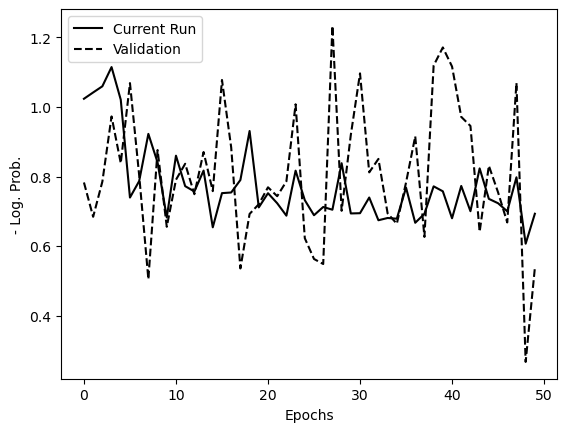

In [147]:
# plot the comparision of the train/val loss for the three scenarios

epoch_list = range(0,200)

plt.plot(epoch_list[:len(train_loss_list)], train_loss_list[:len(train_loss_list)], label = 'Current Run', color = 'k')
plt.plot(epoch_list[:len(val_loss_list)], val_loss_list[:len(val_loss_list)], label = 'Validation', color = 'k', linestyle = 'dashed')
plt.ylabel('- Log. Prob.')
plt.xlabel('Epochs')
plt.legend()

In [30]:
test_data_loader_flow = DataLoader(df_test1, batch_size=500, shuffle=False)

In [48]:
print(df_test1.shape)
#print unique shapes of data_shifted_test
unique_shapes = set(tuple(data_shifted_test[i].shape) for i in range(len(data_shifted_test)))
print("Unique shapes in data_shifted_test:", unique_shapes)

print(data_shifted_test[0])

(16000, 12)
Unique shapes in data_shifted_test: {(500, 3, 32)}
tensor([[[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        ...,

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]],

        [[22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.],
         [22., 22., 22.,  ..., 22., 22., 22.]]])


In [39]:
import torch
from torch.utils.data import Dataset, DataLoader

# Assume 'device' is defined globally, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# If not, you might need to pass it or ensure tensors are on the correct device later.
# device = torch.device("cpu") # Placeholder, replace with your actual device

class Flow_data(Dataset):
    def __init__(self, data_shifted_flow, param_shifted_flow, num_lc_flow):
        super().__init__()
        self.data_shifted_flow = data_shifted_flow
        self.param_shifted_flow = param_shifted_flow
        self.num_lc_flow = num_lc_flow

    def __len__(self):
        return self.num_lc_flow

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (
            self.param_shifted_flow[idx].to(device),
            self.data_shifted_flow[idx].to(device),
        )

# --- Assuming param_shifted_test and data_shifted_test are lists of PyTorch tensors ---

# Example dummy data for demonstration
# # In your actual code, these would be your loaded lists of tensors
# param_shifted_test = [torch.randn(1, 3) for _ in range(500)] # List of 500 (1,3) tensors
# data_shifted_test = [torch.randn(1, 3, 33) for _ in range(500)] # List of 500 (1,3,33) tensors

# 1. Concatenate the lists of tensors into single tensors
#    This is crucial because your Flow_data.__getitem__ expects to index a single tensor.
concatenated_param_shifted_test = torch.cat(param_shifted_test, dim=0)
concatenated_data_shifted_test = torch.cat(data_shifted_test, dim=0)

# Determine the number of light curves for this specific test set
num_lc_test = len(param_shifted_test) # Or equivalently, len(data_shifted_test)

# 2. Create an instance of your Flow_data Dataset with the concatenated tensors
dataset_for_test = Flow_data(
    data_shifted_flow=concatenated_data_shifted_test,
    param_shifted_flow=concatenated_param_shifted_test,
    num_lc_flow=num_lc_test
)

# 3. Create the DataLoader from this new dataset
test_data_loader_flow = DataLoader(dataset_for_test, batch_size=500, shuffle=False)

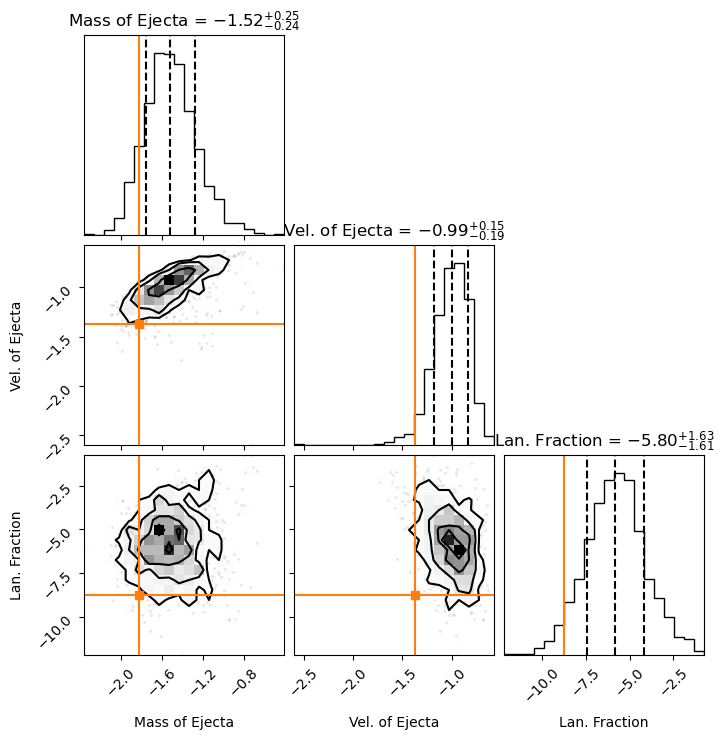

In [106]:
for idx, (shift_test, data_test) in enumerate(test_data_loader_flow):
    print(data_test[0].shape)
    data_test = data_test.reshape((-1,)+data_test.shape[2:])
    shift_test = shift_test.reshape((-1,)+shift_test.shape[2:])
    if idx % 100 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(1000, context=data_test[0].reshape((1, 3, 32)))
    live_plot_samples(samples.cpu().reshape(1000,3), shift_test[0][0].cpu()[...,0:3])
    plt.show()

19:29 bilby INFO    : Key: KS-test p-value
19:29 bilby INFO    : log10_mej: 2.3486269013973844e-294
19:29 bilby INFO    : log10_vej: 0.0
19:29 bilby INFO    : log10_Xlan: 2.2177987455661094e-277
19:29 bilby INFO    : Combined p-value: 0.0


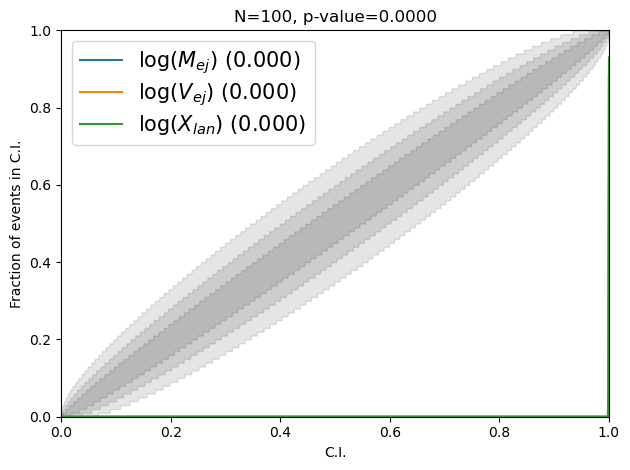

In [153]:
results = []
for i in range(0,100):
    with torch.no_grad():
        samples = flow.sample(20000, context=var_inf_dict['var_data{}'.format(i)][0].reshape((1, 3, num_points)))
    samples = samples.cpu().reshape(20000,3)
    samples[:,0].mul_(mej_max - mej_min).add_(mej_min)
    samples[:,1].mul_(vej_max - vej_min).add_(vej_min)
    samples[:,2].mul_(xlan_max - xlan_min).add_(xlan_min)
    truth = var_inf_dict['var_param{}'.format(i)].cpu()[...,0:3]
    truth = truth.squeeze(1)[0]
    results.append(cast_as_bilby_result(samples, truth, priors))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bilby.result.make_pp_plot(results, save=False, keys=['log10_mej', 'log10_vej', 'log10_Xlan'],
                              confidence_interval = [0.68, 0.95, 0.998], legend_fontsize=15)
plt.savefig('ppplot100.pdf', format="pdf", bbox_inches="tight")